In [ ]:
# Crash Analytics 

In [9]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [11]:
!pip show xgboost

Name: xgboost
Version: 2.1.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: C:\Users\sushant.tamu\AppData\Roaming\Python\Python312\site-packages
Requires: numpy, scipy
Required-by: 


In [1]:
# Import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.naive_bayes import GaussianNB

# Crash Data File

In [2]:
# Import the crashdata file
data_crash= pd.read_csv('20240409 TDR Crash.csv')
#data_crash.head()

C:\Users\sushant.tamu\AppData\Local\Temp\ipykernel_25816\3441948173.py:2: DtypeWarning: Columns (19,34,35,44,46,80,84,91,154,170,171,173,174,175,176,177,178) have mixed types. Specify dtype option on import or set low_memory=False.
  data_crash= pd.read_csv('20240409 TDR Crash.csv')


In [3]:
data_crash.shape # Dimension of the dataframe 

(2705059, 181)

In [545]:
#data_crash.describe(include='all') # This gives the summary or descriptive statistics of all the columns - numeric/categorical excluding the NaN values 

In [3]:
data_crash.info() # Gives information about the non null entries, Number of columns, Datatype; integer64=36, object=65, float64=80

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705059 entries, 0 to 2705058
Columns: 181 entries, Crash_ID to near_Trauma_Center_Distance
dtypes: float64(80), int64(36), object(65)
memory usage: 3.6+ GB


In [4]:
# Check for Missing values in each column 
data_crash.isna().sum()

Crash_ID                             0
Crash_Fatal_Fl                       0
Cmv_Involv_Fl                        0
Schl_Bus_Fl                          0
Rr_Relat_Fl                          0
                                ...   
Investigat_Arrv_Date           2281749
Investigat_Date_Rwy_Clrd       2281706
Investigat_Date_Scn_Clrd       2281758
near_Trauma_Center_ID          2697739
near_Trauma_Center_Distance    2697739
Length: 181, dtype: int64

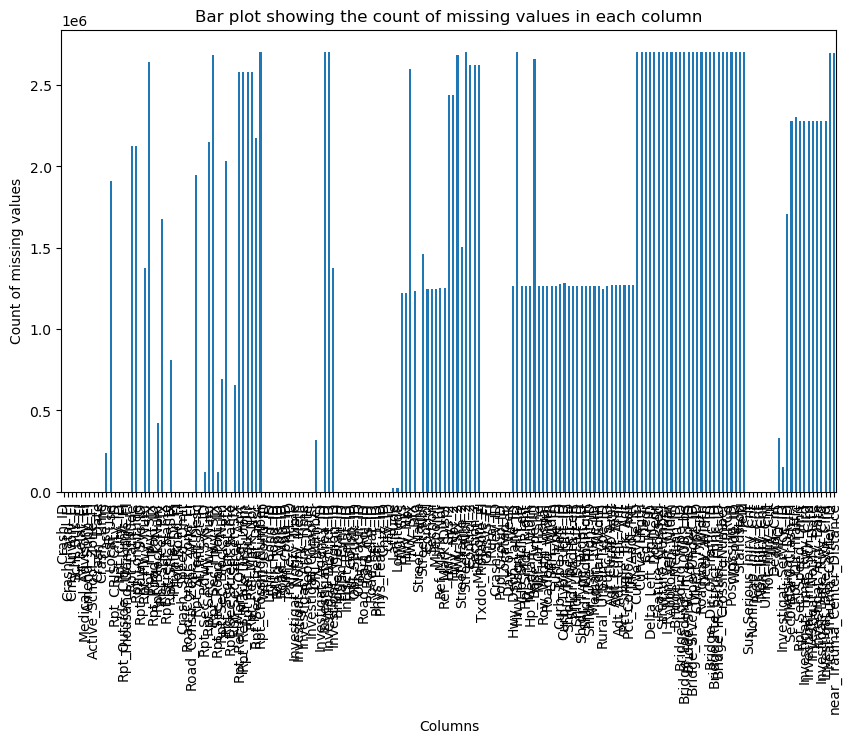

In [5]:
# Distribution of the missing values for each column 
Nan_counts= data_crash.isna().sum()
plt.figure(figsize=(10,6))
Nan_counts.plot(kind='bar')
plt.title('Bar plot showing the count of missing values in each column')
plt.xlabel('Columns')
plt.ylabel('Count of missing values')
plt.show()

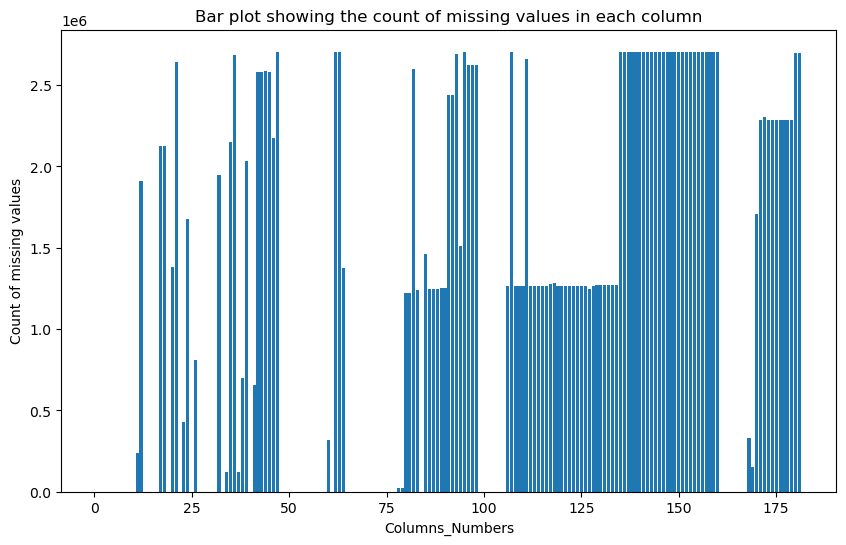

In [6]:
# Change the column names with column numbers in the above plot 
column_numbers = range(1, len(Nan_counts) + 1)
plt.figure(figsize=(10,6))
plt.bar(column_numbers,Nan_counts)
plt.title('Bar plot showing the count of missing values in each column')
plt.xlabel('Columns_Numbers')
plt.ylabel('Count of missing values')
plt.show()

In [8]:
# Percentage of missing values in each column 
na_percent= data_crash.isna().mean()*100
# Filter the columns for which NA values > 50% 
columns1 = na_percent[na_percent > 50].index.tolist()

In [9]:
# Count of the number of columns where NA_values> 50% 
count_columns1= len(columns1)
print(count_columns1)

69


In [10]:
# Drop the columns where NA > 50% 
data_crash1 = data_crash.drop(columns=columns1)
data_crash1.shape

(2705059, 112)

In [17]:
#data_crash1.columns.tolist()

In [11]:
# Filter the crash_IDs for Non-Intersection only. 
data_crash1['At_Intrsct_Fl'].unique()
data_crash2= data_crash1[data_crash1['At_Intrsct_Fl']== 'N' ]

In [12]:
# Export the crash file columns to excel 
columns_filtered = pd.DataFrame(data_crash1.columns, columns=['Column Names'])
columns_filtered.to_excel('filtered_crash_columns.xlsx', index= False)

# Analytics on Unit data file 

In [13]:
# Import the Unit data file
data_unit= pd.read_csv('20240409 tdr unit.csv')
data_unit.head()

C:\Users\sushant.tamu\AppData\Local\Temp\ipykernel_25816\1833082262.py:2: DtypeWarning: Columns (44,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data_unit= pd.read_csv('20240409 tdr unit.csv')


,Crash_ID,Unit_Nbr,Unit_Desc_ID,Veh_Parked_Fl,Veh_HNR_Fl,Veh_Lic_State_ID,VIN,Veh_Mod_Year,Veh_Color_ID,Veh_Make_ID,...,CMV_Actual_Gross_Weight,Pedestrian_Action_ID,Pedalcyclist_Action_ID,PBCAT_Pedestrian_ID,PBCAT_Pedalcyclist_ID,E_Scooter_ID,Autonomous_Unit_ID,Respndr_Strck_Fl,Rpt_Autonomous_Unit_ID,Rpt_Autonomous_Level_Engaged_ID
0,13808771,1,1,N,N,43.0,1FT8W3BT2CEA64817,2012.0,21.0,37.0,...,NaN,97.0,97.0,97.0,97.0,97.0,2.0,NaN,NaN,NaN
1,13808771,2,1,N,N,43.0,4A3AJ56G2WE037806,1998.0,9.0,68.0,...,NaN,97.0,97.0,97.0,97.0,97.0,2.0,NaN,NaN,NaN
2,15581806,1,1,N,N,43.0,1N6ND11S6HC381893,1987.0,3.0,71.0,...,NaN,95.0,95.0,95.0,95.0,95.0,95.0,NaN,NaN,NaN
3,15581806,2,1,N,N,43.0,1HGEM21271L028336,2001.0,10.0,44.0,...,NaN,95.0,95.0,95.0,95.0,95.0,95.0,NaN,NaN,NaN
4,15585669,1,1,N,N,43.0,1FTPX12504NA69482,2004.0,3.0,37.0,...,NaN,95.0,95.0,95.0,95.0,95.0,95.0,NaN,NaN,NaN


In [14]:
# Dimension
data_unit.shape # There are 5.43 million rows and 82 columns 

(5430935, 82)

In [16]:
# Summaary of the data 
data_unit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430935 entries, 0 to 5430934
Data columns (total 82 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Crash_ID                          int64  
 1   Unit_Nbr                          int64  
 2   Unit_Desc_ID                      int64  
 3   Veh_Parked_Fl                     object 
 4   Veh_HNR_Fl                        object 
 5   Veh_Lic_State_ID                  float64
 6   VIN                               object 
 7   Veh_Mod_Year                      float64
 8   Veh_Color_ID                      float64
 9   Veh_Make_ID                       float64
 10  Veh_Mod_ID                        float64
 11  Veh_Body_Styl_ID                  float64
 12  Emer_Respndr_Fl                   object 
 13  Owner_Lessee                      object 
 14  Ownr_State_ID                     float64
 15  Fin_Resp_Proof_ID                 float64
 16  Fin_Resp_Type_ID                  fl

In [37]:
#data_unit.describe(include='all')

In [32]:
# Check the maximum number of units in the Unit_Nbr column; This gives no of units involved in the crash. 
data_unit['Unit_Nbr'].max()

148

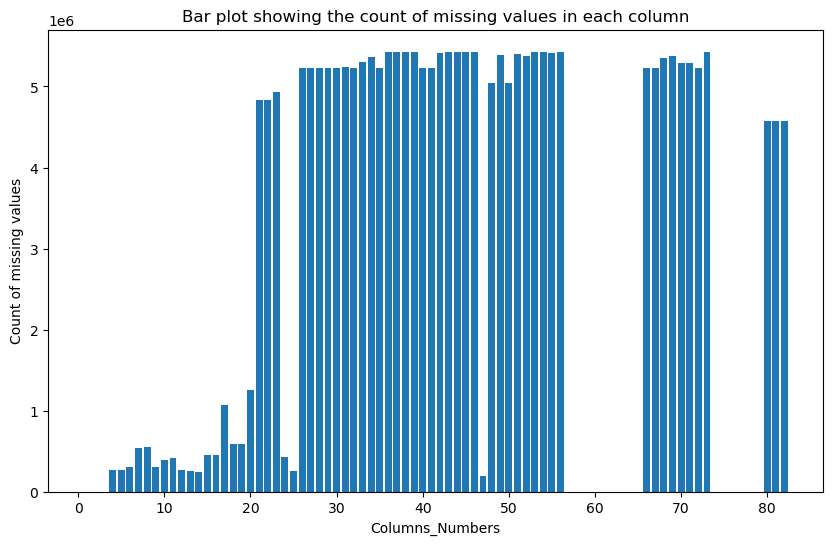

In [34]:
# Distribution of NA values in each column
Nan_count1= data_unit.isna().sum()
column_numbers1 = range(1, len(Nan_count1) + 1)
plt.figure(figsize=(10,6))
plt.bar(column_numbers1,Nan_count1)
plt.title('Bar plot showing the count of missing values in each column')
plt.xlabel('Columns_Numbers')
plt.ylabel('Count of missing values')
plt.show()

# NA values treatment 

In [36]:
# Columns which have NA values > 50% 
unit_na_percent= data_unit.isna().mean()*100
unit_columns1=unit_na_percent[unit_na_percent>50].index.tolist()
count_unit_columns1=len(unit_columns1) # No of columns where NA values > 50% 
count_unit_columns1
data_unit1= data_unit.drop(columns= unit_columns1) # Drop the columns where NA values>50% 
data_unit1.shape

(5430935, 38)

In [38]:
# Create a column; Vehicle = Parked and trucks ( Truck only chosen; i.e ['Veh_Body_Styl_ID'] == 106)
data_unit1['parked_trucks'] = (data_unit1['Veh_Parked_Fl'] == 'Y') &  (data_unit1['Veh_Body_Styl_ID'] == 106).astype(int)

In [39]:
data_unit1.shape

(5430935, 39)

In [43]:
# Crash_IDs for parked trucks only (Select the data for "Truck" only ;  i.e ['Veh_Body_Styl_ID'] == 106) 
df_parked_trucks=data_unit1[data_unit1['parked_trucks']== True] # This gives unique Crash_ID for the parked trucks only 
df_parked_trucks.shape

(4923, 39)

In [45]:
# Finding the count of NA values in each column after filtering down the data for Parked Truck 
df_parked_trucks.isna().sum()

Crash_ID                              0
Unit_Nbr                              0
Unit_Desc_ID                          0
Veh_Parked_Fl                         0
Veh_HNR_Fl                            0
Veh_Lic_State_ID                     32
VIN                                  67
Veh_Mod_Year                         82
Veh_Color_ID                         40
Veh_Make_ID                           0
Veh_Mod_ID                            0
Veh_Body_Styl_ID                      0
Emer_Respndr_Fl                       0
Owner_Lessee                          2
Ownr_State_ID                       280
Fin_Resp_Proof_ID                   109
Fin_Resp_Type_ID                    954
Veh_Damage_Description1_Id          355
Veh_Damage_Severity1_Id             359
Veh_Damage_Direction_Of_Force1_I    838
Veh_Inventoried_Fl                  137
Veh_Cmv_Fl                            0
Contrib_Factr_1_ID                   30
Veh_Trvl_Dir_ID                       0
First_Harm_Evt_Inv_ID                 0


In [47]:
# We need to have the details of all the vehciles in which parked truck is involved. For all the above Crash IDs, get the dataframe such that 
# each crash_ID indicates one of the parked_vehicles is a Truck. 
crash_ids_list = df_parked_trucks['Crash_ID'].tolist()
filtered_df = data_unit1[data_unit1['Crash_ID'].isin(crash_ids_list)]
filtered_df.shape

(11967, 39)

In [49]:
# Find the sum of count of units for each of the crash_ID 
count_units = filtered_df.groupby('Crash_ID')['Unit_Nbr'].count().reset_index()
print(count_units)

      Crash_ID  Unit_Nbr
0     16825520         3
1     16827944         4
2     16828361         2
3     16829468         2
4     16830756         4
...        ...       ...
4787  19998991         3
4788  20002346         2
4789  20039321         2
4790  20083397         3
4791  20111991         3

[4792 rows x 2 columns]


In [51]:
# Filter crash ids where the sum of count of units is 2 or 3 only
filtered_crash_ids = count_units[(count_units['Unit_Nbr'] == 2) | (count_units['Unit_Nbr'] == 3)]['Crash_ID'].tolist()
# Filter the original dataframe based on the crash ids
filtered_df_pt = filtered_df[filtered_df['Crash_ID'].isin(filtered_crash_ids)]
#filtered_df_pt.head(10)
filtered_df_pt.shape

(9938, 39)

In [53]:
# Check the unique values in Unit_Nbr column 
filtered_df_pt['Unit_Nbr'].unique()

array([1, 2, 3], dtype=int64)

In [80]:
# Export the Filtered columns from Unit file to the excel for analysis 
columns_filtered1 = pd.DataFrame(filtered_df_pt.columns, columns=['Column Names'])
columns_filtered1.to_excel('filtered_Unit_columns_onlytruck.xlsx', index= False)

In [55]:
# Pivot the DataFrame; To reshape the Unit_Nbr data into the columns for each feature. Each Crash_ID will be a single row 
pivot_df = filtered_df_pt.pivot(index='Crash_ID', columns='Unit_Nbr')
# Flatten multi-level index and rename columns
pivot_df.columns = [f'Unit{unit}_{feature}' for feature, unit in pivot_df.columns]
pivot_df.reset_index(inplace=True)

In [57]:
# Reorder the columns to group features by unit to get all the features associated with a unit at one place 
units = sorted(set(filtered_df_pt['Unit_Nbr']))
features = [col for col in filtered_df_pt.columns if col not in ['Crash_ID', 'Unit_Nbr']]
ordered_columns = ['Crash_ID'] + [f'Unit{unit}_{feature}' for unit in units for feature in features]
# Reindex the DataFrame to have the columns in the desired order
pivot_df = pivot_df.reindex(columns=ordered_columns)
# Reset the index to make Crash_ID a column again
pivot_df.reset_index(drop= True, inplace=True)

In [59]:
pivot_df.head()

,Crash_ID,Unit1_Unit_Desc_ID,Unit1_Veh_Parked_Fl,Unit1_Veh_HNR_Fl,Unit1_Veh_Lic_State_ID,Unit1_VIN,Unit1_Veh_Mod_Year,Unit1_Veh_Color_ID,Unit1_Veh_Make_ID,Unit1_Veh_Mod_ID,...,Unit3_Unkn_Injry_Cnt,Unit3_Tot_Injry_Cnt,Unit3_Death_Cnt,Unit3_Pedestrian_Action_ID,Unit3_Pedalcyclist_Action_ID,Unit3_PBCAT_Pedestrian_ID,Unit3_PBCAT_Pedalcyclist_ID,Unit3_E_Scooter_ID,Unit3_Autonomous_Unit_ID,Unit3_parked_trucks
0,16825520,1.0,N,N,43.0,1FAFP40493F326631,2003.0,2.0,37.0,96.0,...,0.0,0.0,0.0,95.0,95.0,95.0,95.0,95.0,95.0,True
1,16828361,1.0,N,N,43.0,1G1ZJ57B08F176766,2008.0,11.0,107.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16829468,1.0,N,N,43.0,1J4GX48S63C618198,2003.0,16.0,429.0,1116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16831775,1.0,N,Y,113.0,NaN,NaN,99.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16832240,1.0,N,Y,113.0,NaN,NaN,99.0,208.0,763.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pivot_df.shape

(4340, 112)

In [63]:
pivot_df.isna().sum()

Crash_ID                          0
Unit1_Unit_Desc_ID                0
Unit1_Veh_Parked_Fl               0
Unit1_Veh_HNR_Fl                  0
Unit1_Veh_Lic_State_ID           68
                               ... 
Unit3_PBCAT_Pedestrian_ID      3082
Unit3_PBCAT_Pedalcyclist_ID    3082
Unit3_E_Scooter_ID             3082
Unit3_Autonomous_Unit_ID       3082
Unit3_parked_trucks            3082
Length: 112, dtype: int64

In [65]:
# Check the NaN values 
pivot_na_percent= pivot_df.isna().mean()*100
pivot_columns1=pivot_na_percent[pivot_na_percent>50].index.tolist()
pivot_columns1

['Unit3_Unit_Desc_ID',
 'Unit3_Veh_Parked_Fl',
 'Unit3_Veh_HNR_Fl',
 'Unit3_Veh_Lic_State_ID',
 'Unit3_VIN',
 'Unit3_Veh_Mod_Year',
 'Unit3_Veh_Color_ID',
 'Unit3_Veh_Make_ID',
 'Unit3_Veh_Mod_ID',
 'Unit3_Veh_Body_Styl_ID',
 'Unit3_Emer_Respndr_Fl',
 'Unit3_Owner_Lessee',
 'Unit3_Ownr_State_ID',
 'Unit3_Fin_Resp_Proof_ID',
 'Unit3_Fin_Resp_Type_ID',
 'Unit3_Veh_Damage_Description1_Id',
 'Unit3_Veh_Damage_Severity1_Id',
 'Unit3_Veh_Damage_Direction_Of_Force1_I',
 'Unit3_Veh_Inventoried_Fl',
 'Unit3_Veh_Cmv_Fl',
 'Unit3_Contrib_Factr_1_ID',
 'Unit3_Veh_Trvl_Dir_ID',
 'Unit3_First_Harm_Evt_Inv_ID',
 'Unit3_Sus_Serious_Injry_Cnt',
 'Unit3_Nonincap_Injry_Cnt',
 'Unit3_Poss_Injry_Cnt',
 'Unit3_Non_Injry_Cnt',
 'Unit3_Unkn_Injry_Cnt',
 'Unit3_Tot_Injry_Cnt',
 'Unit3_Death_Cnt',
 'Unit3_Pedestrian_Action_ID',
 'Unit3_Pedalcyclist_Action_ID',
 'Unit3_PBCAT_Pedestrian_ID',
 'Unit3_PBCAT_Pedalcyclist_ID',
 'Unit3_E_Scooter_ID',
 'Unit3_Autonomous_Unit_ID',
 'Unit3_parked_trucks']

In [67]:
len(pivot_columns1) # There are 75 columns which have NA values > 50%. 

37

In [69]:
# Drop those columns where NA values> 50% . 
df_cleaned= pivot_df.drop(columns= pivot_columns1)
df_cleaned.shape

(4340, 75)

In [532]:
#df_cleaned.columns.tolist()

In [71]:
# Show the distribution of Nan Values in the final dataframe 
Nan_cleaned= df_cleaned.isna().sum()

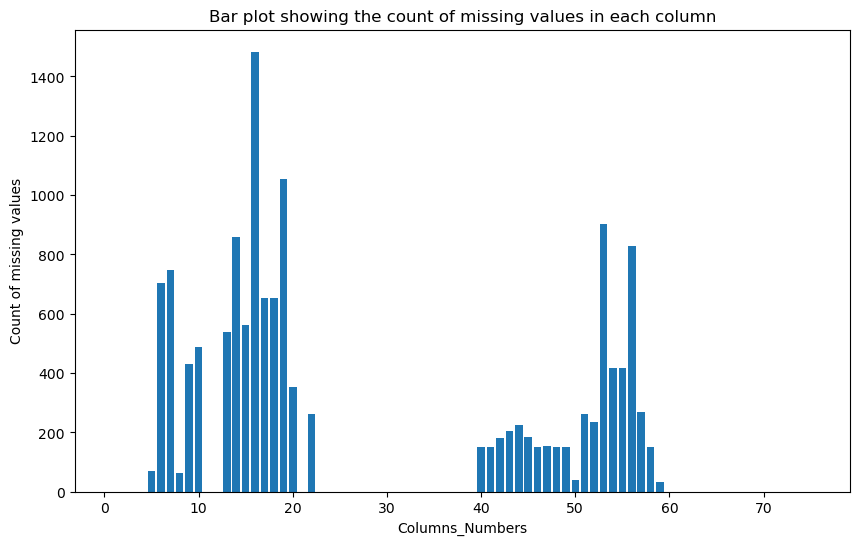

In [73]:
# Distribution of NaN values, column names has been changed to column numbers 
column_numbers = range(1, len(Nan_cleaned) + 1)
plt.figure(figsize=(10,6))
plt.bar(column_numbers,Nan_cleaned)
plt.title('Bar plot showing the count of missing values in each column')
plt.xlabel('Columns_Numbers')
plt.ylabel('Count of missing values')
plt.show()

In [75]:
# Count the unique Crash IDs
Count_CrashID= df_cleaned['Crash_ID'].nunique()
Count_CrashID

4340

In [ ]:
# Merging the filetered Crash_DataFile and Unit_data file 

In [77]:
merged_df = pd.merge(data_crash2, df_cleaned, on='Crash_ID', how='inner')

In [78]:
na_counts_merged=merged_df.isna().sum()
na_counts_merged

Crash_ID                       0
Crash_Fatal_Fl                 0
Cmv_Involv_Fl                  0
Schl_Bus_Fl                    0
Rr_Relat_Fl                    0
                              ..
Unit2_PBCAT_Pedestrian_ID      0
Unit2_PBCAT_Pedalcyclist_ID    0
Unit2_E_Scooter_ID             0
Unit2_Autonomous_Unit_ID       0
Unit2_parked_trucks            0
Length: 186, dtype: int64

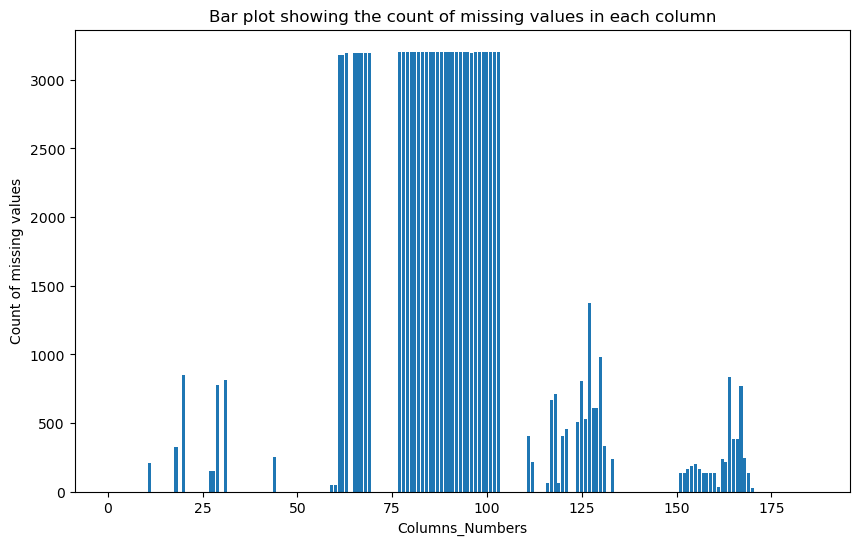

In [79]:
# Distribution of NA values in the merged dataframe 
# Distribution of NaN values, column names has been changed to column numbers 
column_numbers = range(1, len(na_counts_merged) + 1)
plt.figure(figsize=(10,6))
plt.bar(column_numbers,na_counts_merged)
plt.title('Bar plot showing the count of missing values in each column')
plt.xlabel('Columns_Numbers')
plt.ylabel('Count of missing values')
plt.show()

# Classification Models 

# Step1: Select necessary columns from crash_data and Unit_data file, merge them, replace categorical values with meanings 

In [90]:
# Filtering the columns from the crash_data file 
crash_columns= ['Crash_ID',
 'Crash_Fatal_Fl',
 'Cmv_Involv_Fl',
 'Crash_Date',
 'Crash_Time',
 'Private_Dr_Fl',
 'Toll_Road_Fl',
 'Crash_Speed_Limit',
 'Road_Constr_Zone_Fl',
 'Road_Constr_Zone_Wrkr_Fl',
 'Wthr_Cond_ID',
 'Light_Cond_ID',
 'Entr_Road_ID',
 'Road_Type_ID',
 'Road_Algn_ID',
 'Surf_Cond_ID',
 'Traffic_Cntl_ID',
 'Road_Cls_ID',
 'Latitude',
 'Longitude',
 'Hwy_Sys',
 'Rural_Fl',
 'Crash_Sev_ID',
 'Day_of_Week', 
 'Hp_Shldr_Left',
 'Hp_Shldr_Right',
 'Hp_Median_Width',
 'Nbr_Of_Lane',
 'Row_Width_Usual',
 'Roadbed_Width',
 'Surf_Width',
 'Surf_Type_ID',
 'Curb_Type_Left_ID',
 'Curb_Type_Right_ID',
 'Shldr_Type_Left_ID',
 'Shldr_Width_Left',
 'Shldr_Use_Left_ID',
 'Shldr_Type_Right_ID',
 'Shldr_Width_Right',
 'Shldr_Use_Right_ID',
 'Median_Type_ID',
 'Median_Width',
 'Rural_Urban_Type_ID',
 'Func_Sys_ID',
 'Adt_Curnt_Amt',
 'Pct_Single_Trk_Adt',
 'Pct_Combo_Trk_Adt',
 'Trk_Aadt_Pct']

In [92]:
df_crash_model= data_crash2[crash_columns]
df_crash_model.shape

(1839084, 48)

In [94]:
# Filter the columns from Unit_data file  
filtered_unit_columns =['Crash_ID',
 'Unit1_Veh_Body_Styl_ID',
 'Unit1_Owner_Lessee',
 'Unit1_Fin_Resp_Type_ID',
 'Unit1_Veh_Damage_Description1_Id',
 'Unit1_Veh_Damage_Severity1_Id',
 'Unit1_Contrib_Factr_1_ID',
 'Unit2_Veh_Body_Styl_ID',
 'Unit2_Owner_Lessee',
 'Unit2_Fin_Resp_Type_ID',
 'Unit2_Veh_Damage_Description1_Id',
 'Unit2_Veh_Damage_Severity1_Id',
 'Unit2_Contrib_Factr_1_ID']

In [96]:
df_unit_model= df_cleaned[filtered_unit_columns]
df_unit_model.shape

(4340, 13)

# Merge the filtered dataset for model building 

In [662]:
merged_df_model= pd.merge(df_crash_model, df_unit_model, on = 'Crash_ID', how= 'inner')
merged_df_model.shape

(3987, 60)

In [664]:
# Finding count of NA values in each column 
na_counts= merged_df_model.isna().sum()
na_counts

Crash_ID                               0
Crash_Fatal_Fl                         0
Cmv_Involv_Fl                          0
Crash_Date                             0
Crash_Time                             0
Private_Dr_Fl                          0
Toll_Road_Fl                           0
Crash_Speed_Limit                      0
Road_Constr_Zone_Fl                    0
Road_Constr_Zone_Wrkr_Fl               0
Wthr_Cond_ID                           0
Light_Cond_ID                          0
Entr_Road_ID                           0
Road_Type_ID                           0
Road_Algn_ID                           0
Surf_Cond_ID                           0
Traffic_Cntl_ID                        0
Road_Cls_ID                            0
Latitude                              49
Longitude                             49
Hwy_Sys                             3179
Rural_Fl                               0
Crash_Sev_ID                           0
Day_of_Week                            0
Hp_Shldr_Left   

In [666]:
# NA Values Treatment in the merged file 
# Drop the columns where NA values > 50 % 
merged_na_percent= merged_df_model.isna().mean()*100
merged_columns1=merged_na_percent[merged_na_percent>50].index.tolist() 
merged_cleaned= merged_df_model.drop(columns= merged_columns1)
merged_cleaned.shape # This gives the shape of final cleaned dataset 

(3987, 35)

In [668]:
# Count the unique values in each column 
unique_values= merged_cleaned.nunique()
unique_values 

Crash_ID                            3987
Crash_Fatal_Fl                         2
Cmv_Involv_Fl                          2
Crash_Date                          1605
Crash_Time                          1269
Private_Dr_Fl                          1
Toll_Road_Fl                           2
Crash_Speed_Limit                     19
Road_Constr_Zone_Fl                    2
Road_Constr_Zone_Wrkr_Fl               2
Wthr_Cond_ID                           9
Light_Cond_ID                          8
Entr_Road_ID                           9
Road_Type_ID                           5
Road_Algn_ID                           8
Surf_Cond_ID                           9
Traffic_Cntl_ID                       16
Road_Cls_ID                            7
Latitude                            3936
Longitude                           3937
Rural_Fl                               2
Crash_Sev_ID                           6
Day_of_Week                            7
Unit1_Veh_Body_Styl_ID                16
Unit1_Owner_Less

In [670]:
# Count the NA values in each column after dropping the columns with NA values more than 50 %
merged_cleaned.isna().sum()

Crash_ID                               0
Crash_Fatal_Fl                         0
Cmv_Involv_Fl                          0
Crash_Date                             0
Crash_Time                             0
Private_Dr_Fl                          0
Toll_Road_Fl                           0
Crash_Speed_Limit                      0
Road_Constr_Zone_Fl                    0
Road_Constr_Zone_Wrkr_Fl               0
Wthr_Cond_ID                           0
Light_Cond_ID                          0
Entr_Road_ID                           0
Road_Type_ID                           0
Road_Algn_ID                           0
Surf_Cond_ID                           0
Traffic_Cntl_ID                        0
Road_Cls_ID                            0
Latitude                              49
Longitude                             49
Rural_Fl                               0
Crash_Sev_ID                           0
Day_of_Week                            0
Unit1_Veh_Body_Styl_ID                 0
Unit1_Owner_Less

In [672]:
# Changing the column values to specific names 
# Changing the values of the column = 'Wthr_Cond_ID '
mapping = {
'Wthr_Cond_ID':{0:'UNKNOWN',1:'RAIN',2:'SLEET_OR_HAIL',3:'SNOW',4:'FOG',5:'BLOWING_SAND_OR_SNOW',6:'SEVERE_CROSSWINDS',7:'OTHER', 8:'CLEAR',9:'CLOUDY'},
'Light_Cond_ID':{ 0:'UNKNOWN', 1:'DAYLIGHT', 2:'DAWN', 3:'DARK_NOTLIGHTED', 4:'DARK_LIGHTED', 5:'DUSK', 6:'DARK_UNKNOWN_LIGHTING', 7:'OTHER'},
'Entr_Road_ID': {0:'NOT_APPLICABLE', 2:'THREE_ENTERING_ROADS_T',3:'THREE_ENTERING_ROADS_Y',4:'FOUR_ENTERING_ROADS',5:'FIVE_ENTERING ROADS',
                6:'SIX_ENTERING_ROADS', 7:'TRAFFIC_CIRCLE',8:'CLOVERLEAF',98:'OTHER'},
'Road_Type_ID': {1:'TWO_WAY_NOT_DIVIDED',2:'TWO_WAY_DIVIDED_UNPROTECTED_MEDIAN',3:'TW_OWAY_DIVIDED_PROTECTED_MEDIAN',4:'ONE_WAY',98:'OTHER'},
'Road_Algn_ID': {1:'STRAIGHT_LEVEL', 2:'STRAIGHT_GRADE',3:'STRAIGHT_HILLCREST', 4:'CURVE_LEVEL',5:'CURVE_GRADE',6:'CURVE_HILLCREST',7:'OTHER',
           8:'UNKNOWN'},
'Surf_Cond_ID': {0:'UNKNOWN',1:'DRY',2:'WET',3:'STANDING_WATER',5:'SLUSH',6:'ICE',8:'OTHER',9:'SNOW',10:'SAND_MUD_DIRT'},
'Traffic_Cntl_ID': { 0: 'NONE', 1: 'INOPERATIVE' , 2: 'OFFICER',3: 'FLAGMAN', 4:'SIGNAL_LIGHT', 5:'FLASHING_RED_LIGHT', 6:'FLASHING_YELLOW_LIGHT',7:'STOP_SIGN',
                   8:'YIELD SIGN', 9:'WARNING SIGN', 10:'CENTER_STRIPE_OR_DIVIDER', 11:'NO_PASSING_ZONE', 12:'RR_GATE_OR_SIGNAL', 13:'CROSSWALK',14:'BIKE_LANE', 15:'OTHER',
                   16:'MARKED_LANES', 17: 'SIGNAL_LIGHT_WITH_RED_LIGHT_RUNNING_CAMERA'},
'Road_Cls_ID':{1:'INTERSTATE',2:'STATE_HIGHWAYS',3:'FARM_TO_MARKET',4:'COUNTY_ROAD',5:'CITY_STREET',6:'TOLLWAY',7:'OTHER_ROADS', 8:'TOLL_BRIDGES',
              9:'NON_TRAFFICWAY'},
'Crash_Sev_ID': {0:'UNKNOWN', 1:'INCAPACITATING INJURY', 1:'SUSPECTED SERIOUS INJURY', 2:'NON-INCAPACITATING INJURY', 2:'SUSPECTED MINOR INJURY',
                 3:'POSSIBLE_INJURY', 4:'KILLED', 4:'FATAL_INJURY', 5: 'NOT_INJURED'},
#day_week={1: 'MON',2:'TUE',3:'WED',4:'THU',5:'FRI',6:'SAT',7:'SUN'}
'Unit1_Veh_Body_Styl_ID':{0.0: 'UNKNOWN',9.0:'AMBULANCE',23.0:'FIRE TRUCK',3.0:'PICKUP',47.0:'BUS',69.0:'SPORT_UTILITY_VEHICLE',71.0:'MOTORCYCLE',87.0:'TRUCK_TRACTOR',
                      92.0:'OTHER', 100.0:'PASSENGER_CAR_2DOOR',103.0:'VAN',104.0:'PASSENGER_CAR_4DOOR',105.0:'POLICE_CAR_OR_TRUCK',106.0:'TRUCK', 107.0:'YELLOW_SCHOOL_BUS',
                      108.0:'NEIGHBORHOOD_ELECTRIC_VEHICLE'},
'Unit1_Fin_Resp_Type_ID': {1.0:'LIABILITY_INSURANCE_POLICY',2.0:'LIABILITY_INSURANCE_PROOF',3.0:'INSURANCE_BINDER',4.0:'SURETY_BOND',
                         5.0:'DEPOSIT_CERTIFICATE_WITH_COMPTROLLER',7.0:'CERTIFICATE_OF_SELFINSURANCE'},
'Unit1_Veh_Damage_Description1_Id': {1.0:'FRONT_END_DAMAGE_CONCENTRATED_IMPACT',2.0:'FRONT_END_DAMAGE_DISTRIBUTED_IMPACT',3.0:'FRONT_END_LEFT_DAMAGE_PARTIAL_CONTACT',
                        4.0:'FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT', 5.0:'BACK_END_DAMAGE_CONCENTRATED_IMPACT', 6.0:'BACK_END_DAMAGE_DISTRIBUTED_IMPACT',
                        7.0:'BACK_END_LEFT_DAMAGE_PARTIAL_CONTACT', 8.0:'BACK_END_RIGHT_DAMAGE_PARTIAL_CONTACT',9.0:'LEFT_SIDE_DAMAGE_ANGULAR_IMPACT',
                        10.0:'RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT',11.0:'LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT',12.0:'RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT',
                        13.0:'LEFT BACK QUARTER DAMAGE ANGULAR IMPACT', 14.0:'RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT', 15.0:'DISTRIBUTED LEFT SIDE DAMAGE PARALLEL IMPACT',
                        16.0:'DISTRIBUTED_RIGHT_SIDE_DAMAGE_PARALLEL_IMPACT', 17.0:'LEFT_SIDE_AND_TOP_DAMAGE_ROLLOVER_EFFECTS',18.0:'RIGHT_SIDE_AND_TOP_DAMAGE_ROLLOVER_EFFECTS',
                        23.0:'NOT_APPLICABLE', 26.0:'MOTORCYCLE_SCOOTER_MOPED_ONLY',27.0:'TOP_DAMAGE_ONLY', 27.0:'TOP_DAMAGE',
                        28.0:'VEHICLE_BURNED', 29.0:'UNDERCARRIAGE_DAMAGE_ONLY',29.0:'UNDERCARRIAGE_DAMAGE'},
'Unit1_Veh_Damage_Severity1_Id':{ 0.0:'NO_DAMAGE',1.0:'DAMAGED1_MINIMUM', 2.0:	'DAMAGED2', 3.0:'DAMAGED3', 4.0:'DAMAGED4',5.0:'DAMAGED5', 6.0:'DAMAGED6', 7.0:'DAMAGED7_HIGHEST'},
'Unit1_Contrib_Factr_1_ID': {0.0:'NONE', 1.0:'ANIMAL_ON_ROAD_DOMESTIC', 2.0: 'ANIMAL_ON_ROAD_WILD',3.0: 'BACKED_WITHOUT_SAFETY', 4.0:'CHANGED_LANE_WHEN_UNSAFE',
                           16.0:'DISREGARD_STOPSIGN_OR_LIGHT',17.0:'DISREGARD_TURN_MARKS_AT_INTERSECTION',18.0:'DISREGARD_WARNING_SIGN_AT_CONSTRUCTION',
                           19.0:'DISTRACTION_IN_VEHICLE', 20.0:'DRIVER_INATTENTION',21.0:'DROVE_WITHOUT_HEADLIGHTS',22.0:'FAILED_TO_CONTROL_SPEED',
                           23.0:'FAILED_TO_DRIVE_IN_SINGLE_LANE',24.0:'FAILED_TO_GIVE_HALF_OF_ROADWAY',25.0:'FAILED_TO_HEED_WARNING_SIGN',
                           26.0:'FAILED_TO_PASS_TO_LEFT_SAFELY',27.0:'FAILED_TO_PASS_TO_RIGHT_SAFELY',
                           34.0:'FAILED_TO_YIELD_RIGHT_OF_WAY_PRIVATE_DRIVE',37.0:'FAILED_TO_YIELD_RIGHT_OF_WAY_TURNING_LEFT',39.0:'FAILED_TO_YIELD_RIGHT_OF_WAY_YIELD_SIGN',
                           40.0:'FATIGUED_OR_ASLEEP',41.0:'FAULTY_EVASIVE_ACTION',43.0:'FLEEING_OR_EVADING_POLICE',44.0:'FOLLOWED_TOO_CLOSELY',45.0:'HAD_BEEN_DRINKING',
                           47.0:'ILL',48.0:'IMPAIRED_VISIBILITY',49.0:'IMPROPER_START_FROM_PARKED_POSITION',50.0:'LOAD_NOT_SECURED',52.0:'OVERSIZED_VEHICLE_OR_LOAD',
                           53.0:'OVERTAKE_AND_PASS_INSUFFICIENT_CLEARANCE',54.0:'PARKED_AND_FAILED_TO_SET_BRAKES',55.0:'PARKED_IN_TRAFFIC_LANE',
                           57.0:'PASSED_IN_NO_PASSING_LANE',58.0:'PASSED_ON_RIGHT-SHOULDER',59.0:	'PEDESTRIAN_FAILED_TO_YIELD_RIGHT_OF_WAY_TO_VEHICLE',
                           60.0:'UNSAFE_SPEED',61.0:'SPEEDING_OVERLIMIT',62.0:'TAKING_MEDICATION',63.0:'TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT',64.0:'TURNED_IMPROPERLY_WIDE_RIGHT',
                           65.0:'TURNED_IMPROPERLY_WRONG_LANE',66.0:'TURNED_WHEN_UNSAFE',67.0:'UNDER_INFLUENCE_ALCOHOL',68.0:'UNDER_INFLUENCE_DRUG',
                           69.0:'WRONG_SIDE_APPROACH_OR_INTERSECTION',70.0:'WRONG_SIDE_NOT_PASSING',71.0:'WRONG WAY_ONE_WAY_ROAD',73.0:'ROAD_RAGE',74.0:'OTHER',
                           75.0:'CELL_OR_MOBILE_TALKING',76.0:'CELL_OR_MOBILE_TEXTING',77.0:'CELL_OR_MOBILE_OTHER',78.0:'CELL_OR_MOBILE_UNKNOWN',
                           79.0:'FAILED_TO_SLOW_OR_MOVE_FOR_VEHICLES_DISPLAYING_EMERGENCY_LIGHTS'},
'Unit2_Veh_Body_Styl_ID':{0.0: 'UNKNOWN',30.0:'PICKUP',69.0:'SPORT UTILITY VEHICLE',71.0:'MOTORCYCLE',92.0:'OTHER',
                    100.0:'PASSENGER_CAR_2DOOR',101.0:'FARM EQUIPMENT',103.0:'VAN',104.0:'PASSENGER_CAR_4DOOR',105.0:'POLICE_CAR_OR_TRUCK',106.0:'TRUCK'},
'Unit2_Fin_Resp_Type_ID':{1.0:'LIABILITY_INSURANCE_POLICY',2.0:'LIABILITY_INSURANCE_PROOF',3.0:'INSURANCE_BINDER',4.0:'SURETY_BOND',
                         5.0:'DEPOSIT_CERTIFICATE_WITH_COMPTROLLER',6.0:'DEPOSIT_CERTIFICATE_WITH_COUNTY_JUDGE', 7.0:'CERTIFICATE_OF_SELFINSURANCE'},
'Unit2_Veh_Damage_Description1_Id':{1.0:'FRONT_END_DAMAGE_CONCENTRATED_IMPACT',2.0:'FRONT_END_DAMAGE_DISTRIBUTED_IMPACT',3.0:'FRONT_END_LEFT_DAMAGE_PARTIAL_CONTACT',
                        4.0:'FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT', 5.0:'BACK_END_DAMAGE_CONCENTRATED_IMPACT', 6.0:'BACK_END_DAMAGE_DISTRIBUTED_IMPACT',
                        7.0:'BACK_END_LEFT_DAMAGE_PARTIAL_CONTACT', 8.0:'BACK_END_RIGHT_DAMAGE_PARTIAL_CONTACT',9.0:'LEFT_SIDE_DAMAGE_ANGULAR_IMPACT',
                        10.0:'RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT',11.0:'LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT',12.0:'RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT',
                        13.0:'LEFT BACK QUARTER DAMAGE ANGULAR IMPACT', 14.0:'RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT', 15.0:'DISTRIBUTED LEFT SIDE DAMAGE PARALLEL IMPACT',
                        16.0:'DISTRIBUTED_RIGHT_SIDE_DAMAGE_PARALLEL_IMPACT', 17.0:'LEFT_SIDE_AND_TOP_DAMAGE_ROLLOVER_EFFECTS',18.0:'RIGHT_SIDE_AND_TOP_DAMAGE_ROLLOVER_EFFECTS',
                        23.0:'NOT_APPLICABLE',27.0:'TOP_DAMAGE_ONLY', 27.0:'TOP_DAMAGE'},
'Unit2_Veh_Damage_Severity1_Id':{ 0.0:'NO DAMAGE',1.0:'DAMAGED1_MINIMUM', 2.0:	'DAMAGED2', 3.0:'DAMAGED3', 4.0:'DAMAGED4',5.0:'DAMAGED5', 6.0:'DAMAGED6', 
                                7.0:'DAMAGED7_HIGHEST'},
'Unit2_Contrib_Factr_1_ID':{0.0:'NONE', 1.0:'ANIMAL_ON_ROAD_DOMESTIC', 2.0: 'ANIMAL_ON_ROAD_WILD',3.0: 'BACKED_WITHOUT_SAFETY', 4.0:'CHANGED_LANE_WHEN_UNSAFE',
                           14.0:'DISABLED_IN_TRAFFIC_LANE',16.0:'DISREGARD_STOPSIGN_OR_LIGHT', 19.0:'DISTRACTION_IN_VEHICLE', 20.0:'DRIVER_INATTENTION',
                           22.0:'FAILED_TO_CONTROL_SPEED',23.0:'FAILED_TO_DRIVE_IN_SINGLE_LANE',26.0:'FAILED_TO_PASS_TO_LEFT_SAFELY',
                           27.0:'FAILED_TO_PASS_TO_RIGHT_SAFELY',34.0:'FAILED_TO_YIELD_RIGHT_OF_WAY_PRIVATE_DRIVE',37.0:'FAILED_TO_YIELD_RIGHT_OF_WAY_TURNING_LEFT',
                           40.0:'FATIGUED_OR_ASLEEP',41.0:'FAULTY_EVASIVE_ACTION',45.0:'HAD_BEEN_DRINKING',
                           47.0:'ILL', 50.0:'LOAD_NOT_SECURED',51.0:'OPENED_DOOR_INTO_TRAFFIC_LANE',52.0:'OVERSIZED_VEHICLE_OR_LOAD',55.0:'PARKED_IN_TRAFFIC_LANE',
                           56.0:'PARKED_WITHOUT_LIGHTS',60.0:'UNSAFE_SPEED',63.0:'TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT',64.0:'TURNED_IMPROPERLY_WIDE_RIGHT',
                           67.0:'UNDER_INFLUENCE_ALCOHOL',73.0:'ROAD_RAGE',74.0:'OTHER',78.0:'CELL_OR_MOBILE_UNKNOWN'}
}

In [674]:
# Replace values in each column using the mapping dictionary, preserving NaN
for column, map_dict in mapping.items():
    merged_cleaned[column] = merged_cleaned[column].replace(map_dict, inplace=False)

In [676]:
merged_cleaned.head()

,Crash_ID,Crash_Fatal_Fl,Cmv_Involv_Fl,Crash_Date,Crash_Time,Private_Dr_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,...,Unit1_Fin_Resp_Type_ID,Unit1_Veh_Damage_Description1_Id,Unit1_Veh_Damage_Severity1_Id,Unit1_Contrib_Factr_1_ID,Unit2_Veh_Body_Styl_ID,Unit2_Owner_Lessee,Unit2_Fin_Resp_Type_ID,Unit2_Veh_Damage_Description1_Id,Unit2_Veh_Damage_Severity1_Id,Unit2_Contrib_Factr_1_ID
0,19471399,N,N,04/03/2023,13:42,N,N,30,N,N,...,LIABILITY_INSURANCE_PROOF,FRONT_END_DAMAGE_DISTRIBUTED_IMPACT,DAMAGED3,FAILED_TO_CONTROL_SPEED,TRUCK,OWNER,LIABILITY_INSURANCE_PROOF,BACK_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED2,NONE
1,19473377,N,N,04/04/2023,6:37,N,N,30,N,N,...,LIABILITY_INSURANCE_PROOF,LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,DAMAGED3,OTHER,TRUCK,OWNER,NaN,LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,DAMAGED3,NONE
2,19473821,N,N,04/03/2023,0:44,N,N,30,N,N,...,NaN,NaN,NaN,NONE,TRUCK,OWNER,LIABILITY_INSURANCE_PROOF,FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED2,NONE
3,19476481,N,N,04/04/2023,5:33,N,N,65,N,N,...,LIABILITY_INSURANCE_PROOF,DISTRIBUTED_RIGHT_SIDE_DAMAGE_PARALLEL_IMPACT,DAMAGED2,DRIVER_INATTENTION,UNKNOWN,OWNER,NaN,NaN,NaN,NONE
4,19478484,N,N,04/02/2023,23:07,N,N,30,N,N,...,NaN,FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED4,FAILED_TO_DRIVE_IN_SINGLE_LANE,TRUCK,OWNER,NaN,BACK_END_LEFT_DAMAGE_PARTIAL_CONTACT,DAMAGED1_MINIMUM,NONE


In [678]:
merged_cleaned1= merged_cleaned

In [680]:
# Drop some of the columns - Crash_ID, Crash_Date, Crash_Time,Longitude, Latitude before correlation 
merged_cleaned1.drop(columns=['Crash_ID','Crash_Date','Crash_Time', 'Latitude','Longitude','Day_of_Week'], inplace= True)
merged_cleaned1.head()

,Crash_Fatal_Fl,Cmv_Involv_Fl,Private_Dr_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Wthr_Cond_ID,Light_Cond_ID,Entr_Road_ID,...,Unit1_Fin_Resp_Type_ID,Unit1_Veh_Damage_Description1_Id,Unit1_Veh_Damage_Severity1_Id,Unit1_Contrib_Factr_1_ID,Unit2_Veh_Body_Styl_ID,Unit2_Owner_Lessee,Unit2_Fin_Resp_Type_ID,Unit2_Veh_Damage_Description1_Id,Unit2_Veh_Damage_Severity1_Id,Unit2_Contrib_Factr_1_ID
0,N,N,N,N,30,N,N,11,DAYLIGHT,OTHER,...,LIABILITY_INSURANCE_PROOF,FRONT_END_DAMAGE_DISTRIBUTED_IMPACT,DAMAGED3,FAILED_TO_CONTROL_SPEED,TRUCK,OWNER,LIABILITY_INSURANCE_PROOF,BACK_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED2,NONE
1,N,N,N,N,30,N,N,11,DAYLIGHT,THREE_ENTERING_ROADS_T,...,LIABILITY_INSURANCE_PROOF,LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,DAMAGED3,OTHER,TRUCK,OWNER,NaN,LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,DAMAGED3,NONE
2,N,N,N,N,30,N,N,11,DARK_LIGHTED,NOT_APPLICABLE,...,NaN,NaN,NaN,NONE,TRUCK,OWNER,LIABILITY_INSURANCE_PROOF,FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED2,NONE
3,N,N,N,N,65,N,N,11,DARK_LIGHTED,NOT_APPLICABLE,...,LIABILITY_INSURANCE_PROOF,DISTRIBUTED_RIGHT_SIDE_DAMAGE_PARALLEL_IMPACT,DAMAGED2,DRIVER_INATTENTION,UNKNOWN,OWNER,NaN,NaN,NaN,NONE
4,N,N,N,N,30,N,N,11,DARK_LIGHTED,NOT_APPLICABLE,...,NaN,FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED4,FAILED_TO_DRIVE_IN_SINGLE_LANE,TRUCK,OWNER,NaN,BACK_END_LEFT_DAMAGE_PARTIAL_CONTACT,DAMAGED1_MINIMUM,NONE


In [682]:
merged_cleaned1['Crash_Speed_Limit'].value_counts() # Gives the distribution of the crash IDs for different speed limits 

Crash_Speed_Limit
 30    1875
 35     567
 25     187
 20     179
 45     162
-1      161
 70     145
 65     144
 40     132
 60     101
 55      97
 75      81
 15      63
 50      52
 10      20
 5       10
 80       9
 34       1
 14       1
Name: count, dtype: int64

In [684]:
merged_cleaned1.drop(columns=['Private_Dr_Fl'],inplace= True) # As there is no variation in the above column, it is dropped 

# Step 2. Cramer's V Coorelation between the Categorical Variables 

In [158]:
pip install association-metrics

In [686]:
# Import association_metrics  
import association_metrics as am

# Convert you str columns to Category columns
df = merged_cleaned1.apply(
        lambda x: x.astype("category") if x.dtype == "O" else x)

# Initialize a CamresV object using you pandas.DataFrame
cramersv = am.CramersV(df) 
# returns a pairwise matrix filled with Cramer's V, 
cramers_matrix=cramersv.fit()
cramers_matrix

,Crash_Fatal_Fl,Cmv_Involv_Fl,Toll_Road_Fl,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Wthr_Cond_ID,Light_Cond_ID,Entr_Road_ID,Road_Type_ID,Road_Algn_ID,...,Unit1_Fin_Resp_Type_ID,Unit1_Veh_Damage_Description1_Id,Unit1_Veh_Damage_Severity1_Id,Unit1_Contrib_Factr_1_ID,Unit2_Veh_Body_Styl_ID,Unit2_Owner_Lessee,Unit2_Fin_Resp_Type_ID,Unit2_Veh_Damage_Description1_Id,Unit2_Veh_Damage_Severity1_Id,Unit2_Contrib_Factr_1_ID
Crash_Fatal_Fl,1.000000,0.087343,0.012896,0.038994,0.035841,0.017382,0.061737,0.036820,0.106985,0.066552,...,0.016594,0.173703,0.169971,0.215888,0.021177,0.008837,0.046763,0.111808,0.057298,0.080263
Cmv_Involv_Fl,0.087343,1.000000,0.103192,0.187405,0.177121,0.078460,0.168931,0.119620,0.222725,0.135930,...,0.180715,0.152171,0.102229,0.227736,0.086834,0.067523,0.136819,0.144751,0.134116,0.160076
Toll_Road_Fl,0.012896,0.103192,1.000000,0.143363,0.145640,0.024238,0.058430,0.060284,0.254687,0.101337,...,0.078958,0.085631,0.065554,0.128172,0.023804,0.016220,0.047671,0.099666,0.041838,0.131040
Road_Constr_Zone_Fl,0.038994,0.187405,0.143363,1.000000,0.872046,0.074196,0.068561,0.092314,0.320475,0.099095,...,0.085983,0.113221,0.059382,0.271461,0.046870,0.053301,0.129529,0.155690,0.052892,0.099510
Road_Constr_Zone_Wrkr_Fl,0.035841,0.177121,0.145640,0.872046,1.000000,0.058785,0.085818,0.076401,0.291490,0.094800,...,0.086756,0.100800,0.030227,0.275623,0.040963,0.049442,0.135627,0.156448,0.059934,0.103790
Wthr_Cond_ID,0.017382,0.078460,0.024238,0.074196,0.058785,1.000000,0.241080,0.041235,0.048388,0.108449,...,0.044678,0.119106,0.051222,0.119714,0.035878,0.024591,0.033973,0.066632,0.057493,0.058678
Light_Cond_ID,0.061737,0.168931,0.058430,0.068561,0.085818,0.241080,1.000000,0.040176,0.065326,0.083286,...,0.056366,0.112933,0.094186,0.151783,0.048419,0.059299,0.044470,0.081196,0.080445,0.078349
Entr_Road_ID,0.036820,0.119620,0.060284,0.092314,0.076401,0.041235,0.040176,1.000000,0.149093,0.060848,...,0.057479,0.076891,0.062230,0.146432,0.039496,0.047362,0.041308,0.072984,0.051193,0.130593
Road_Type_ID,0.106985,0.222725,0.254687,0.320475,0.291490,0.048388,0.065326,0.149093,1.000000,0.184198,...,0.057030,0.112935,0.094609,0.180796,0.062257,0.034612,0.055711,0.128471,0.049489,0.107061
Road_Algn_ID,0.066552,0.135930,0.101337,0.099095,0.094800,0.108449,0.083286,0.060848,0.184198,1.000000,...,0.037609,0.087681,0.048087,0.134747,0.030826,0.050539,0.031694,0.071366,0.044682,0.059047


In [688]:
# Filter the highly coorelated features 
# Set the threshold for high correlation
import numpy as np
threshold = 0.8

# Create a mask to ignore the upper triangle and the diagonal
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))

# Apply the mask to the correlation matrix
corr_matrix_masked = cramers_matrix.mask(mask)

# Filter out the pairs with correlation values above the threshold
high_corr_pairs = corr_matrix_masked.stack()[corr_matrix_masked.stack().abs() > threshold]
high_corr_pairs

Road_Constr_Zone_Wrkr_Fl  Road_Constr_Zone_Fl    0.872046
Road_Cls_ID               Toll_Road_Fl           0.846298
Crash_Sev_ID              Crash_Fatal_Fl         1.000000
dtype: float64

# Encoding binary variables 

In [693]:
# Replace the binary columns with 0 and 1 
#Replace "Yes" with 1 and "No" with 0
merged_cleaned1['Crash_Fatal_Fl'] = merged_cleaned1['Crash_Fatal_Fl'].replace({'Y': 1, 'N': 0})
merged_cleaned1['Cmv_Involv_Fl'] = merged_cleaned1['Cmv_Involv_Fl'].replace({'Y': 1, 'N': 0})
#merged_cleaned1['Private_Dr_Fl'] = merged_cleaned1['Private_Dr_Fl'].replace({'Y': 1, 'N': 0})
merged_cleaned1['Toll_Road_Fl'] = merged_cleaned1['Toll_Road_Fl'].replace({'Y': 1, 'N': 0})
merged_cleaned1['Road_Constr_Zone_Fl'] = merged_cleaned1['Road_Constr_Zone_Fl'].replace({'Y': 1, 'N': 0})
merged_cleaned1['Road_Constr_Zone_Wrkr_Fl'] = merged_cleaned1['Road_Constr_Zone_Wrkr_Fl'].replace({'Y': 1, 'N': 0})
merged_cleaned1['Rural_Fl'] = merged_cleaned1['Rural_Fl'].replace({'Y': 1, 'N': 0})
merged_cleaned1['Unit1_Owner_Lessee'] = merged_cleaned1['Unit1_Owner_Lessee'].replace({'OWNER': 1, 'LESSEE': 0})
merged_cleaned1['Unit2_Owner_Lessee'] = merged_cleaned1['Unit2_Owner_Lessee'].replace({'OWNER': 1, 'LESSEE': 0})
merged_cleaned1.head()

,Crash_Fatal_Fl,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Wthr_Cond_ID,Light_Cond_ID,Entr_Road_ID,Road_Type_ID,...,Unit1_Fin_Resp_Type_ID,Unit1_Veh_Damage_Description1_Id,Unit1_Veh_Damage_Severity1_Id,Unit1_Contrib_Factr_1_ID,Unit2_Veh_Body_Styl_ID,Unit2_Owner_Lessee,Unit2_Fin_Resp_Type_ID,Unit2_Veh_Damage_Description1_Id,Unit2_Veh_Damage_Severity1_Id,Unit2_Contrib_Factr_1_ID
0,0,0,0,30,0,0,11,DAYLIGHT,OTHER,TWO_WAY_NOT_DIVIDED,...,LIABILITY_INSURANCE_PROOF,FRONT_END_DAMAGE_DISTRIBUTED_IMPACT,DAMAGED3,FAILED_TO_CONTROL_SPEED,TRUCK,1.0,LIABILITY_INSURANCE_PROOF,BACK_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED2,NONE
1,0,0,0,30,0,0,11,DAYLIGHT,THREE_ENTERING_ROADS_T,TWO_WAY_NOT_DIVIDED,...,LIABILITY_INSURANCE_PROOF,LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,DAMAGED3,OTHER,TRUCK,1.0,NaN,LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,DAMAGED3,NONE
2,0,0,0,30,0,0,11,DARK_LIGHTED,NOT_APPLICABLE,TWO_WAY_NOT_DIVIDED,...,NaN,NaN,NaN,NONE,TRUCK,1.0,LIABILITY_INSURANCE_PROOF,FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED2,NONE
3,0,0,0,65,0,0,11,DARK_LIGHTED,NOT_APPLICABLE,TW_OWAY_DIVIDED_PROTECTED_MEDIAN,...,LIABILITY_INSURANCE_PROOF,DISTRIBUTED_RIGHT_SIDE_DAMAGE_PARALLEL_IMPACT,DAMAGED2,DRIVER_INATTENTION,UNKNOWN,1.0,NaN,NaN,NaN,NONE
4,0,0,0,30,0,0,11,DARK_LIGHTED,NOT_APPLICABLE,TWO_WAY_NOT_DIVIDED,...,NaN,FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,DAMAGED4,FAILED_TO_DRIVE_IN_SINGLE_LANE,TRUCK,1.0,NaN,BACK_END_LEFT_DAMAGE_PARTIAL_CONTACT,DAMAGED1_MINIMUM,NONE


# One Hot encoding 

In [696]:
# Use one hot encoding to conver the categorical(Nominal Data) to 0 and 1; Nominal Data: Categorical variables where there is no order. 
# Define column indices for one-hot encoding
column_indices = [6,7,8,9,10,11,12,13,16,18,19,21,22,24,25,27]

# Perform one-hot encoding on the specified columns
df_encoded = pd.get_dummies(merged_cleaned1, columns=merged_cleaned1.columns[column_indices],dummy_na=True) # This creates a separate column of dummy NA
df_encoded.shape

(3987, 270)

In [698]:
df_encoded.head()

,Crash_Fatal_Fl,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,...,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_OVERSIZED_VEHICLE_OR_LOAD,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,Unit2_Contrib_Factr_1_ID_PARKED_WITHOUT_LIGHTS,Unit2_Contrib_Factr_1_ID_ROAD_RAGE,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_WIDE_RIGHT,Unit2_Contrib_Factr_1_ID_UNDER_INFLUENCE_ALCOHOL,Unit2_Contrib_Factr_1_ID_UNSAFE_SPEED,Unit2_Contrib_Factr_1_ID_nan
0,0,0,0,30,0,0,0,NOT_INJURED,1.0,DAMAGED3,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,30,0,0,0,NOT_INJURED,1.0,DAMAGED3,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,30,0,0,0,UNKNOWN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,65,0,0,0,NOT_INJURED,1.0,DAMAGED2,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,30,0,0,0,UNKNOWN,1.0,DAMAGED4,...,False,False,False,False,False,False,False,False,False,False


In [700]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Columns: 270 entries, Crash_Fatal_Fl to Unit2_Contrib_Factr_1_ID_nan
dtypes: bool(258), float64(2), int64(7), object(3)
memory usage: 1.3+ MB


In [702]:
df_encoded['Crash_Sev_ID'].unique()

array(['NOT_INJURED', 'UNKNOWN', 'POSSIBLE_INJURY',
       'SUSPECTED MINOR INJURY', 'SUSPECTED SERIOUS INJURY',
       'FATAL_INJURY'], dtype=object)

In [704]:
df_encoded['Unit1_Veh_Damage_Severity1_Id'].unique()

array(['DAMAGED3', nan, 'DAMAGED2', 'DAMAGED4', 'DAMAGED1_MINIMUM',
       'DAMAGED6', 'DAMAGED5', 'DAMAGED7_HIGHEST', 'NO_DAMAGE'],
      dtype=object)

In [706]:
df_encoded['Unit2_Veh_Damage_Severity1_Id'].unique()

array(['DAMAGED2', 'DAMAGED3', nan, 'DAMAGED1_MINIMUM', 'DAMAGED4',
       'DAMAGED5', 'NO DAMAGE', 'DAMAGED6', 'DAMAGED7_HIGHEST'],
      dtype=object)

# label_Encoding 

In [709]:
# Label Encoding- To encode the ordinal columns(categorical variables with a particlar order)
# Define the mappings for each ordinal variable
# Define the order 

Crash_Sev_Order = {'UNKNOWN':0,'NOT_INJURED':1,'POSSIBLE_INJURY':2,'SUSPECTED MINOR INJURY':3,'NON-INCAPACITATING INJURY':3,'INCAPACITATING INJURY':4,'SUSPECTED SERIOUS INJURY':4,
                  'FATAL_INJURY':5,'KILLED':5}
Unit1Damage_Severity= {'NO DAMAGE':0,'DAMAGED1_MINIMUM':1, 'DAMAGED2':2,'DAMAGED3':3,'DAMAGED4':4,'DAMAGED5':5, 'DAMAGED6':6,'DAMAGED7_HIGHEST':7}
Unit2Damage_Severity= {'NO DAMAGE':0,'DAMAGED1_MINIMUM':1, 'DAMAGED2':2,'DAMAGED3':3,'DAMAGED4':4,'DAMAGED5':5, 'DAMAGED6':6,'DAMAGED7_HIGHEST':7}


# Replace values in the DataFrame
df_encoded['Crash_Sev_ID'] = df_encoded['Crash_Sev_ID'].map(Crash_Sev_Order)
df_encoded['Unit1_Veh_Damage_Severity1_Id'] = df_encoded['Unit1_Veh_Damage_Severity1_Id'].map(Unit1Damage_Severity)
df_encoded['Unit2_Veh_Damage_Severity1_Id'] = df_encoded['Unit2_Veh_Damage_Severity1_Id'].map(Unit2Damage_Severity)

df_encoded.head()

,Crash_Fatal_Fl,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,...,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_OVERSIZED_VEHICLE_OR_LOAD,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,Unit2_Contrib_Factr_1_ID_PARKED_WITHOUT_LIGHTS,Unit2_Contrib_Factr_1_ID_ROAD_RAGE,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_WIDE_RIGHT,Unit2_Contrib_Factr_1_ID_UNDER_INFLUENCE_ALCOHOL,Unit2_Contrib_Factr_1_ID_UNSAFE_SPEED,Unit2_Contrib_Factr_1_ID_nan
0,0,0,0,30,0,0,0,1,1.0,3.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,30,0,0,0,1,1.0,3.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,30,0,0,0,0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,65,0,0,0,1,1.0,2.0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,30,0,0,0,0,1.0,4.0,...,False,False,False,False,False,False,False,False,False,False


In [711]:
# Drop the NaN columns created after performing one hot encoding 
# Identify NaN columns (columns ending with '_nan')
nan_columns = [col for col in df_encoded.columns if col.endswith('_nan')]

# Drop NaN columns
df_final = df_encoded.drop(columns=nan_columns)
df_final.head()

,Crash_Fatal_Fl,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,...,Unit2_Contrib_Factr_1_ID_OPENED_DOOR_INTO_TRAFFIC_LANE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_OVERSIZED_VEHICLE_OR_LOAD,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,Unit2_Contrib_Factr_1_ID_PARKED_WITHOUT_LIGHTS,Unit2_Contrib_Factr_1_ID_ROAD_RAGE,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_WIDE_RIGHT,Unit2_Contrib_Factr_1_ID_UNDER_INFLUENCE_ALCOHOL,Unit2_Contrib_Factr_1_ID_UNSAFE_SPEED
0,0,0,0,30,0,0,0,1,1.0,3.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,30,0,0,0,1,1.0,3.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,30,0,0,0,0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,65,0,0,0,1,1.0,2.0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,30,0,0,0,0,1.0,4.0,...,False,False,False,False,False,False,False,False,False,False


In [713]:
# Convert the boolean columns to integers 0 and 1 
# Find boolean columns
boolean_columns = df_final.columns[df_final.dtypes == bool]
df_final[boolean_columns] = df_final[boolean_columns].astype(int)  # Convert True/False to 1/0

In [715]:
df_final.head()

,Crash_Fatal_Fl,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,...,Unit2_Contrib_Factr_1_ID_OPENED_DOOR_INTO_TRAFFIC_LANE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_OVERSIZED_VEHICLE_OR_LOAD,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,Unit2_Contrib_Factr_1_ID_PARKED_WITHOUT_LIGHTS,Unit2_Contrib_Factr_1_ID_ROAD_RAGE,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT,Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_WIDE_RIGHT,Unit2_Contrib_Factr_1_ID_UNDER_INFLUENCE_ALCOHOL,Unit2_Contrib_Factr_1_ID_UNSAFE_SPEED
0,0,0,0,30,0,0,0,1,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,30,0,0,0,1,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,30,0,0,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,65,0,0,0,1,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,30,0,0,0,0,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [717]:
# There is one Numerical column, Crash_Speed_limit; Normalize that 
# Extract the numerical column to be normalized
numerical_column = 'Crash_Speed_Limit'

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical column
df_final[numerical_column] = scaler.fit_transform(df_final[[numerical_column]])

# Check the distribution of the values in the target Variable before dropping NA 

In [719]:
# Check the distribution of the values in the target Variable befre dropping NA 
value_counts_y=df_final['Crash_Sev_ID'].value_counts()
value_counts_y

Crash_Sev_ID
1    2217
0     981
2     380
3     309
4      74
5      26
Name: count, dtype: int64

In [721]:
# Check the variance of all the columns 
variance= df_final.var()
print(variance)

Crash_Fatal_Fl                                                   0.006480
Cmv_Involv_Fl                                                    0.167496
Toll_Road_Fl                                                     0.017253
Crash_Speed_Limit                                                0.036304
Road_Constr_Zone_Fl                                              0.064881
                                                                   ...   
Unit2_Contrib_Factr_1_ID_ROAD_RAGE                               0.000251
Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_CUT_CORNER_ON_LEFT    0.000502
Unit2_Contrib_Factr_1_ID_TURNED_IMPROPERLY_WIDE_RIGHT            0.000251
Unit2_Contrib_Factr_1_ID_UNDER_INFLUENCE_ALCOHOL                 0.000502
Unit2_Contrib_Factr_1_ID_UNSAFE_SPEED                            0.000502
Length: 254, dtype: float64


In [723]:
df_final.shape

(3987, 254)

In [725]:
df_final_withNA=df_final

In [727]:
# Drop the rows containing NA values 
df_withoutna=df_final.dropna()
df_withoutna.shape

(2882, 254)

# Distribution of NA after dropping NA values 

In [729]:
# Check the distribution of the values in the target Variable after dropping NA 
value_counts1_y=df_withoutna['Crash_Sev_ID'].value_counts()
value_counts1_y

Crash_Sev_ID
1    1817
0     399
2     313
3     268
4      66
5      19
Name: count, dtype: int64

In [731]:
# Identify columns with variance <0.01 
low_variance_columns = variance[variance<= 0.01].index

# Drop columns with variance < 1% 
df_final = df_withoutna.drop(columns=low_variance_columns)
df_final.shape

(2882, 112)

# I- Binary Classification without SMOTE 

In [733]:
# Convert the Target to binary classification; Serious Injury =4,5; All other types, Minor or No Injury 
threshold_severity = 4
df_final['SeverityBinary'] = (df_final['Crash_Sev_ID'] >= threshold_severity).astype(int)
df_final['SeverityBinary'].value_counts() # This gives Serious_Injury = 85 while Minor or No Injury= 2797

C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\340588112.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['SeverityBinary'] = (df_final['Crash_Sev_ID'] >= threshold_severity).astype(int)


SeverityBinary
0    2797
1      85
Name: count, dtype: int64

In [735]:
y = df_final['SeverityBinary'] # Create a column of the binary target variable 
# For the x variables, drop the y variable and correlated features from the dataframe 
X=df_final.drop(columns=['Crash_Sev_ID', 'SeverityBinary'], axis=1)

In [737]:
# Check for NA values in the X and y variable 
X.isna().sum().sum()
y.isna().sum()

0

In [739]:
# Fit the models 
# 1. XGBoost 
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the XGBoost classifier
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_clf.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy}")
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))

XGBoost Accuracy: 0.9601386481802426
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       563
           1       0.09      0.07      0.08        14

    accuracy                           0.96       577
   macro avg       0.53      0.53      0.53       577
weighted avg       0.96      0.96      0.96       577

[[553  10]
 [ 13   1]]


In [747]:
# 2. Random Forest Classifier 
# Instantiate Random Forest classifier with regularization (max_depth)
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# Perform cross-validation
cv_scores_rf = cross_val_score(rf_clf, X_train, y_train, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", cv_scores_rf)
print("Mean cross-validation score:", np.mean(cv_scores_rf))

# Fit the model on the training data
rf_clf.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy_rf = rf_clf.score(X_test, y_test)
print("Test set accuracy:", test_accuracy_rf)

Cross-validation scores: [0.96963124 0.96963124 0.96963124 0.96963124 0.96746204]
Mean cross-validation score: 0.9691973969631237
Test set accuracy: 0.975736568457539


In [748]:
# Feature importance 
# X contains encoded features and y is target variable
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                                    importance
Unit1_Veh_Damage_Severity1_Id                         0.084280
Crash_Speed_Limit                                     0.072627
Unit2_Veh_Damage_Severity1_Id                         0.046234
Cmv_Involv_Fl                                         0.026534
Unit1_Veh_Body_Styl_ID_PASSENGER_CAR_4DOOR            0.023013
...                                                        ...
Unit1_Veh_Damage_Description1_Id_BACK_END_RIGHT...    0.000100
Unit1_Veh_Body_Styl_ID_TRUCK_TRACTOR                  0.000091
Light_Cond_ID_UNKNOWN                                 0.000027
Wthr_Cond_ID_UNKNOWN                                  0.000021
Unit1_Veh_Damage_Description1_Id_BACK_END_LEFT_...    0.000014

[111 rows x 1 columns]


In [749]:
 # 3. Support Vector Machine 
# Instantiate SVM classifier for binary classification
from sklearn.svm import SVC
svm_clf = SVC(kernel='linear', random_state=42)

# Fit the classifier on the training data
svm_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.975736568457539
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       563
           1       0.00      0.00      0.00        14

    accuracy                           0.98       577
   macro avg       0.49      0.50      0.49       577
weighted avg       0.95      0.98      0.96       577



C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [753]:
# 4. Naive Bayes Classifier 
from sklearn.naive_bayes import MultinomialNB 
# Instantiate Multinomial Naive Bayes classifier
mnb = MultinomialNB()

# Fit the classifier on the training data
mnb.fit(X_train, y_train)

# Predict on the test data
y_pred = mnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9098786828422877


In [251]:
pip install xgboost

# Multi class Classification without SMOTE

In [755]:
# Create three class for the target variable; 0 and 1: No Injury, 2,3,4: Injury, 5: Fatal 
bins= [1,3]

# Use np.digitize to bin the values into three classes
y_binned = np.digitize(df_final['Crash_Sev_ID'], bins=bins)
df_final['y_binned'] = y_binned
df_final.head()

C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\1139344156.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y_binned'] = y_binned


,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,Unit2_Owner_Lessee,...,Unit2_Veh_Damage_Description1_Id_LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Contrib_Factr_1_ID_NONE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,SeverityBinary,y_binned
0,0,0,0.382716,0,0,0,1,1.0,3.0,1.0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0.382716,0,0,0,1,1.0,3.0,1.0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0.382716,0,0,0,0,1.0,4.0,1.0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0.382716,0,0,0,2,1.0,3.0,1.0,...,0,0,0,0,0,1,0,0,0,1
6,0,0,0.000000,0,0,0,1,1.0,3.0,1.0,...,0,0,0,0,0,1,0,0,0,1


In [757]:
df_final.shape

(2882, 114)

In [759]:
# Distribution of values in the target variable 
value_counts_target=df_final['y_binned'].value_counts()
value_counts_target

y_binned
1    2130
0     399
2     353
Name: count, dtype: int64

In [761]:
df_multiclass= df_final.drop(['SeverityBinary'], axis=1)
df_multiclass.head()

,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,Unit2_Owner_Lessee,...,Unit2_Veh_Damage_Description1_Id_LEFT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Contrib_Factr_1_ID_NONE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,y_binned
0,0,0,0.382716,0,0,0,1,1.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0.382716,0,0,0,1,1.0,3.0,1.0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,0.382716,0,0,0,0,1.0,4.0,1.0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0.382716,0,0,0,2,1.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,1
6,0,0,0.000000,0,0,0,1,1.0,3.0,1.0,...,1,0,0,0,0,0,1,0,0,1


In [763]:
X_m=df_multiclass.drop(['Crash_Sev_ID','y_binned'], axis=1)
X_m.shape

(2882, 111)

In [765]:
y_m=df_multiclass['y_binned']

In [767]:
# Fit the models 
# 1. XGBoost 
# Split the dataset into training and testing sets
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

# Instantiate the XGBoost classifier for multi-class classification
xgb_clfm = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Fit the model
xgb_clfm.fit(X_train_m, y_train_m)

# Predict the test set
y_pred_m = xgb_clfm.predict(X_test_m)

# Evaluate the model
accuracy = accuracy_score(y_test_m, y_pred_m)
conf_matrix = confusion_matrix(y_test_m, y_pred_m)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7348353552859619
Confusion Matrix:
 [[ 21  52   1]
 [ 18 390  24]
 [  4  54  13]]


In [769]:
# 2. Naive Baye's Classifier 
# Instantiate the Naive Bayes classifier
nb_clf = CategoricalNB()

# Fit the model
nb_clf.fit(X_train_m, y_train_m)

# Predict the test set
y_pred_m = nb_clf.predict(X_test_m)

# Evaluate the model
accuracy = accuracy_score(y_test_m, y_pred_m)
conf_matrix = confusion_matrix(y_test_m, y_pred_m)
print(accuracy)
print(conf_matrix)

0.6724436741767764
[[ 30  40   4]
 [ 35 321  76]
 [  5  29  37]]


In [771]:
# 3. Random Forest Classifier 

# Instantiate the Random Forest classifier
rf_clfm = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_clfm.fit(X_train_m, y_train_m)

# Predict on the test set
y_pred_m = rf_clfm.predict(X_test_m)

# Evaluate the model
accuracy_m = accuracy_score(y_test_m, y_pred_m)
conf_matrix_m = confusion_matrix(y_test_m, y_pred_m)

print("Accuracy:", accuracy_m)
print("Confusion Matrix:\n", conf_matrix_m)

Accuracy: 0.7764298093587522
Confusion Matrix:
 [[ 17  57   0]
 [  6 421   5]
 [  0  61  10]]


# XGboost without dropping NA values 

In [773]:
df_final_withNA.shape

(3987, 254)

In [775]:
# Identify columns with variance <0.01 
low_variance_columns = variance[variance<= 0.01].index

# Drop columns with variance < 1% 
df_final1 = df_final_withNA.drop(columns=low_variance_columns)
df_final1.shape

(3987, 112)

In [777]:
# Convert the Target to binary classification; Serious Injury =4,5; All other types, Minor or No Injury 
threshold_severity = 4
df_final1['SeverityBinary'] = (df_final1['Crash_Sev_ID'] >= threshold_severity).astype(int)
df_final1['SeverityBinary'].value_counts() # This gives Fatal Numbers = 19 while Non-Fatal= 2863 

C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\1160016023.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final1['SeverityBinary'] = (df_final1['Crash_Sev_ID'] >= threshold_severity).astype(int)


SeverityBinary
0    3887
1     100
Name: count, dtype: int64

In [779]:
# Without performing SMOTE 

In [781]:
y1 = df_final1['SeverityBinary'] # Create a column of the binary target variable 

In [783]:
# For the x variables, drop the y variable and correlated features from the dataframe 
X1=df_final1.drop(columns=['Crash_Sev_ID', 'SeverityBinary'], axis=1)
X1.head()

,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,Unit2_Owner_Lessee,Unit2_Veh_Damage_Severity1_Id,...,Unit2_Veh_Damage_Description1_Id_FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,Unit2_Veh_Damage_Description1_Id_LEFT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Contrib_Factr_1_ID_NONE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE
0,0,0,0.382716,0,0,0,1.0,3.0,1.0,2.0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0.382716,0,0,0,1.0,3.0,1.0,3.0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,0.382716,0,0,0,NaN,NaN,1.0,2.0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0.814815,0,0,0,1.0,2.0,1.0,NaN,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0.382716,0,0,0,1.0,4.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [785]:
# Fit the models XGBoost without dropping NA values. No SMOT performed. 
# XGBoost 
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Instantiate the XGBoost classifier
xgb_clf1 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Fit the model
xgb_clf1.fit(X_train, y_train)

# Make predictions
xgb_pred1 = xgb_clf1.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_pred1)
print(f"XGBoost Accuracy: {xgb_accuracy}")
print("Classification Report:\n", classification_report(y_test, xgb_pred1))
print(confusion_matrix(y_test, xgb_pred1))

XGBoost Accuracy: 0.9674185463659147
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       774
           1       0.38      0.12      0.19        24

    accuracy                           0.97       798
   macro avg       0.67      0.56      0.59       798
weighted avg       0.96      0.97      0.96       798

[[769   5]
 [ 21   3]]


# SMOTE Analysis - To Balance the Training data 

In [787]:
# XGBoost after performing SMOTE analysis. SMOTE can be applied only with data having non NA values 
from imblearn.over_sampling import SMOTE

# Building Binary Classification using SMOTE 

In [790]:
y2=df_final['SeverityBinary'] # Create a column of the binary target variable 

In [792]:
# For the x variables, drop the y variable and correlated features from the dataframe 
X2=df_final.drop(columns=['Crash_Sev_ID', 'SeverityBinary'], axis=1)
X2.head()

,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,Unit2_Owner_Lessee,Unit2_Veh_Damage_Severity1_Id,...,Unit2_Veh_Damage_Description1_Id_LEFT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Contrib_Factr_1_ID_NONE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,y_binned
0,0,0,0.382716,0,0,0,1.0,3.0,1.0,2.0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0.382716,0,0,0,1.0,3.0,1.0,3.0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,0.382716,0,0,0,1.0,4.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0.382716,0,0,0,1.0,3.0,1.0,4.0,...,0,0,0,0,0,0,1,0,0,1
6,0,0,0.000000,0,0,0,1.0,3.0,1.0,2.0,...,1,0,0,0,0,0,1,0,0,1


In [794]:
y2.isna().sum()

0

In [796]:
X2.isna().sum().sum()

0

In [798]:
# Apply SMOTE to the training set
# Splitting the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train2, y_train2)

# Step 5: Check the resampled class distribution
print(f"Resampled training set class distribution: {y_train_res.value_counts()}")

Resampled training set class distribution: SeverityBinary
0    2234
1    2234
Name: count, dtype: int64


In [800]:
# Instantiate the XGBoost classifier
xgb_clf2 = XGBClassifier(n_estimators=120, eval_metric='logloss', random_state=42)

# Fit the model
xgb_clf2.fit(X_train_res, y_train_res)

# Fit the model
#xgb_clf2.fit(X_train2, y_train2)

# Make predictions
xgb_pred2 = xgb_clf2.predict(X_test2)

# Evaluate the model
xgb_accuracy2 = accuracy_score(y_test2, xgb_pred2)
print(f"XGBoost Accuracy: {xgb_accuracy}")
print("Classification Report:\n", classification_report(y_test2, xgb_pred2))
print(confusion_matrix(y_test2, xgb_pred2))

XGBoost Accuracy: 0.9674185463659147
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       563
           1       0.24      0.29      0.26        14

    accuracy                           0.96       577
   macro avg       0.61      0.63      0.62       577
weighted avg       0.96      0.96      0.96       577

[[550  13]
 [ 10   4]]


In [918]:
# Modify the learning algorithm to give higher penalty to misclassifying minority class examples.
# In XGBoost, you can use the scale_pos_weight parameter to adjust the balance between positive and negative classes.
# Define the XGBoost model with balanced class weights

xgb1 = XGBClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb1, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

# Fit the gridsearch model and get the best parameters
grid_search.fit(X_train, y_train)

# Train the best model
best_model = grid_search.best_estimator_

# Make predictions and evaluate the model
xgb_pred3 = best_model.predict(X_test2)
y_pred_proba = best_model.predict_proba(X_test2)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test2, y_pred_proba))
print("Classification Report:\n", classification_report(y_test2, xgb_pred3))
print("Confusion Matrix:\n", confusion_matrix(y_test2, xgb_pred3))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
ROC AUC Score: 0.9606698807409286
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       563
           1       0.29      0.43      0.34        14

    accuracy                           0.96       577
   macro avg       0.64      0.70      0.66       577
weighted avg       0.97      0.96      0.96       577

Confusion Matrix:
 [[548  15]
 [  8   6]]


In [803]:
# 2. Naive Baye's Classifier 
# Instantiate the Naive Bayes classifier
nb_clf3 = CategoricalNB()

# Fit the model
nb_clf3.fit(X_train_res, y_train_res)

# Predict the test set
y_pred_3 = nb_clf3.predict(X_test2)

# Evaluate the model
accuracy3 = accuracy_score(y_test2, y_pred_3)
conf_matrix3 = confusion_matrix(y_test2, y_pred_3)
print(accuracy3)
print(conf_matrix3)

0.9566724436741768
[[546  17]
 [  8   6]]


In [ ]:
# _m : multi, _ms: multi and smote 

# SMOTE/Multiclass Classification 

In [806]:
# Preparing the dataset 

y_m_smote=df_final['Crash_Sev_ID'] # Create a column of the multiclass target variable 
# Define a mapping for the new classes; # Create three class for the target variable; 0 and 1: No Injury, 2,3,4: Injury, 5: Fatal 
class_mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4:1,5:2}

# Apply the mapping to recode the target variable
y_rebinned = y_m_smote.map(class_mapping)

#Distribution of the New Classes
print("New class distribution:")
print(Counter(y_rebinned))
df_final['y_rebinned'] = y_rebinned
# Drop the variables not required in the X variable 
X_m_smote=df_final.drop(columns=['Crash_Sev_ID','SeverityBinary','y_binned','y_rebinned'],axis=1) 

New class distribution:
Counter({0: 2216, 1: 647, 2: 19})


C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\3023037849.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y_rebinned'] = y_rebinned


In [808]:
X_m_smote.columns 

Index(['Cmv_Involv_Fl', 'Toll_Road_Fl', 'Crash_Speed_Limit',
       'Road_Constr_Zone_Fl', 'Road_Constr_Zone_Wrkr_Fl', 'Rural_Fl',
       'Unit1_Owner_Lessee', 'Unit1_Veh_Damage_Severity1_Id',
       'Unit2_Owner_Lessee', 'Unit2_Veh_Damage_Severity1_Id',
       ...
       'Unit2_Veh_Damage_Description1_Id_FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT',
       'Unit2_Veh_Damage_Description1_Id_LEFT BACK QUARTER DAMAGE ANGULAR IMPACT',
       'Unit2_Veh_Damage_Description1_Id_LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT',
       'Unit2_Veh_Damage_Description1_Id_LEFT_SIDE_DAMAGE_ANGULAR_IMPACT',
       'Unit2_Veh_Damage_Description1_Id_RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT',
       'Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT',
       'Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT',
       'Unit2_Contrib_Factr_1_ID_NONE', 'Unit2_Contrib_Factr_1_ID_OTHER',
       'Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE'],
      dtype='object', length=111

# (a) SMOTE with Equal balancing 

In [826]:
# Split the dataset into training and test sets
X_trainms, X_testms, y_trainms, y_testms = train_test_split(X_m_smote, y_rebinned, test_size=0.2, random_state=59, stratify=y_rebinned)

# Apply SMOTE to the training data
smote = SMOTE(random_state=59)
X_train_resampled, y_train_resampled = smote.fit_resample(X_trainms, y_trainms)
# Check the resampled class distribution
print("Resampled class distribution:")
print(Counter(y_train_resampled))

Resampled class distribution:
Counter({1: 1772, 0: 1772, 2: 1772})


In [830]:
# 1. Train an XGBoost model using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb_model_ms = XGBClassifier(random_state=59) # Define the model

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model_ms, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Train the model with the best parameters on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_cv = best_model.predict(X_testms)
accuracy = accuracy_score(y_testms, y_pred_cv)

print("Test set accuracy: ", accuracy)
print("Classification report:\n", classification_report(y_testms, y_pred_cv))
print("Confusion Matrix:\n", confusion_matrix(y_testms, y_pred_cv))

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.8937467728587697
Test set accuracy:  0.7608318890814558
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       444
           1       0.46      0.29      0.35       129
           2       0.00      0.00      0.00         4

    accuracy                           0.76       577
   macro avg       0.43      0.40      0.40       577
weighted avg       0.73      0.76      0.74       577

0.7608318890814558
Confusion Matrix:
 [[402  41   1]
 [ 88  37   4]
 [  1   3   0]]


In [839]:
# 2. Train a Naive Bayes classifier 
# Train a Naive Bayes model on the resampled dataset
nb_model_ms = GaussianNB()
nb_model_ms.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_ms2 = nb_model_ms.predict(X_testms)

# Evaluate the model
print("Classification Report:\n", classification_report(y_testms, y_pred_ms2))
print("Confusion Matrix:\n", confusion_matrix(y_testms, y_pred_ms2))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.51      0.64       444
           1       0.29      0.70      0.41       129
           2       0.00      0.00      0.00         4

    accuracy                           0.55       577
   macro avg       0.38      0.40      0.35       577
weighted avg       0.72      0.55      0.59       577

Confusion Matrix:
 [[228 215   1]
 [ 37  90   2]
 [  1   3   0]]


In [832]:
# 3. Train SVM classifier 
# Train an SVM model on the resampled dataset
svm_modelms = SVC(kernel='linear', random_state=59)  # You can choose other kernels like 'rbf' or 'poly'
svm_modelms.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_ms3 = svm_modelms.predict(X_testms)

# Evaluate the model
print("Classification Report:\n", classification_report(y_testms, y_pred_ms3))
print("Confusion Matrix:\n", confusion_matrix(y_testms, y_pred_ms3))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87       444
           1       0.52      0.22      0.31       129
           2       0.00      0.00      0.00         4

    accuracy                           0.78       577
   macro avg       0.44      0.39      0.39       577
weighted avg       0.73      0.78      0.74       577

Confusion Matrix:
 [[420  24   0]
 [101  28   0]
 [  2   2   0]]


C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 # (b) Over Sampling of Minority Class

In [841]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_m_smote, y_rebinned, test_size=0.2, random_state=55, stratify=y_rebinned)

In [843]:
# Experiment with different sampling strategies
# Define custom sampling strategy, Over sampling for only the minority class
# 1. Train a RF classifier 
sampling_strategy = {
    1: 800,   # Number of samples for class 1
    2: 500    # Number of samples for class 2
}

# Apply SMOTE with the specified sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=55)
X_resampled3, y_resampled3 = smote.fit_resample(X_train3, y_train3)

model_rf3 = RandomForestClassifier(random_state=42)
model_rf3.fit(X_resampled3, y_resampled3)
    
y_pred_rf3 = model_rf3.predict(X_test3)
print(classification_report(y_test3, y_pred_rf3))

# Print confusion matrix
cm = confusion_matrix(y_test3, y_pred_rf3)
print("Confusion Matrix:")
print(cm)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       444
           1       0.50      0.31      0.38       129
           2       0.00      0.00      0.00         4

    accuracy                           0.77       577
   macro avg       0.44      0.41      0.42       577
weighted avg       0.74      0.77      0.75       577

Confusion Matrix:
[[406  38   0]
 [ 89  40   0]
 [  2   2   0]]


C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [845]:
# 2. XGBoost Classifier with new sampling strategy
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(xgb_model_ms, param_grid, cv=5, scoring='accuracy')
grid_search1.fit(X_resampled3, y_resampled3)

print("Best parameters:", grid_search1.best_params_)
print("Best cross-validation accuracy:", grid_search1.best_score_)

# Train the model with the best parameters on the entire training set
best_model1 = grid_search1.best_estimator_
best_model1.fit(X_train3, y_train3)

# Evaluate the model on the test set
y_pred_cv1 = best_model.predict(X_test3)
accuracy1 = accuracy_score(y_test3, y_pred_cv1)

print("Test set accuracy: ", accuracy1)
print("Classification report:\n", classification_report(y_test3, y_pred_cv1))

# Print confusion matrix
cm1 = confusion_matrix(y_test3, y_pred_cv1) #labels=np.unique(y))
print("Confusion Matrix:")
print(cm1)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.8170954159052991
Test set accuracy:  0.9185441941074524
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       444
           1       0.85      0.78      0.81       129
           2       1.00      0.50      0.67         4

    accuracy                           0.92       577
   macro avg       0.93      0.75      0.81       577
weighted avg       0.92      0.92      0.92       577

Confusion Matrix:
[[428  16   0]
 [ 29 100   0]
 [  0   2   2]]


# (c) Drop '0: Unknown' class

In [847]:
df_final['Crash_Sev_ID'].value_counts()

Crash_Sev_ID
1    1817
0     399
2     313
3     268
4      66
5      19
Name: count, dtype: int64

In [849]:
df_final.shape

(2882, 115)

In [851]:
# Filter the values dropping the 0: unknown 
df_new=df_final[df_final['Crash_Sev_ID']!=0]
df_new.shape

(2483, 115)

# Multi class classification/Dropped '0'class/SMOTE

In [853]:
# A. Prepare the dataset 

y_m_smote_new=df_new['Crash_Sev_ID'] # Create a column of the multiclass target variable 

# Define a mapping for the new classes; # Create three class for the target variable; 0 and 1: No Injury, 2,3,4: Injury, 5: Fatal 
class_mapping_new = { 1: 0, 2: 1, 3: 1, 4:1,5:2}

# Apply the mapping to recode the target variable
y_rebinned_new = y_m_smote_new.map(class_mapping_new)

#Distribution of the New Classes
print("New class distribution:")
print(Counter(y_rebinned_new))
df_new['y_rebinned_new'] = y_rebinned_new
# Drop the variables not required in the X variable 
X_m_smote_new=df_new.drop(columns=['Crash_Sev_ID','SeverityBinary','y_binned','y_rebinned','y_rebinned_new'],axis=1) 

New class distribution:
Counter({0: 1817, 1: 647, 2: 19})


C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\3709379381.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['y_rebinned_new'] = y_rebinned_new
C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\3709379381.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['y_rebinned_new'] = y_rebinned_new


In [855]:
X_m_smote_new.head()

,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,Unit2_Owner_Lessee,Unit2_Veh_Damage_Severity1_Id,...,Unit2_Veh_Damage_Description1_Id_FRONT_END_RIGHT_DAMAGE_PARTIAL_CONTACT,Unit2_Veh_Damage_Description1_Id_LEFT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_LEFT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT BACK QUARTER DAMAGE ANGULAR IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Contrib_Factr_1_ID_NONE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE
0,0,0,0.382716,0,0,0,1.0,3.0,1.0,2.0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0.382716,0,0,0,1.0,3.0,1.0,3.0,...,0,0,0,1,0,0,0,1,0,0
5,0,0,0.382716,0,0,0,1.0,3.0,1.0,4.0,...,1,0,0,0,0,0,0,1,0,0
6,0,0,0.000000,0,0,0,1.0,3.0,1.0,2.0,...,0,1,0,0,0,0,0,1,0,0
7,0,0,0.197531,0,0,1,1.0,2.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [857]:
#Distribution of the New Classes
print("New class distribution:")
print(Counter(y_rebinned_new))

New class distribution:
Counter({0: 1817, 1: 647, 2: 19})


In [863]:
# B. Perform SMOTE and split the dataset
# Split the dataset into training and test sets
X_trainms1, X_testms1, y_trainms1, y_testms1 = train_test_split(X_m_smote_new, y_rebinned_new, test_size=0.2, random_state=79)

# 1. Train a RF classifier 
sampling_strategy1 = {
    1: 800,   # Number of samples for class 1
    2: 500    # Number of samples for class 2
}
# Apply SMOTE with the specified sampling strategy
smote1 = SMOTE(sampling_strategy=sampling_strategy1, random_state=69)
X_train_resampled4, y_train_resampled4 = smote1.fit_resample(X_trainms1, y_trainms1)

# Check the resampled class distribution
print("Resampled class distribution:")
print(Counter(y_train_resampled4))

Resampled class distribution:
Counter({0: 1455, 1: 800, 2: 500})


In [867]:
# C. 1. Train an XGBoost model using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb_model_ms1 = XGBClassifier(random_state=79) # Define the model

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(xgb_model_ms1, param_grid, cv=5, scoring='accuracy')
grid_search1.fit(X_train_resampled4, y_train_resampled4)

print("Best parameters:", grid_search1.best_params_)
print("Best cross-validation accuracy:", grid_search1.best_score_)

# Train the model with the best parameters on the entire training set
best_model1 = grid_search1.best_estimator_
best_model1.fit(X_train_resampled4, y_train_resampled4)

# Evaluate the model on the test set
y_pred_cv_ms1 = best_model1.predict(X_testms1)
accuracy1 = accuracy_score(y_testms1, y_pred_cv_ms1)

print("Test set accuracy: ", accuracy1)
print("Classification report:\n", classification_report(y_testms1, y_pred_cv_ms1))
cm_xgb_model_ms1 = confusion_matrix(y_testms1, y_pred_cv_ms1) 
print("Confusion Matrix:")
print(cm_xgb_model_ms1)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.8021778584392015
Test set accuracy:  0.7283702213279678
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       362
           1       0.49      0.36      0.42       132
           2       0.00      0.00      0.00         3

    accuracy                           0.73       497
   macro avg       0.43      0.41      0.42       497
weighted avg       0.71      0.73      0.71       497

Confusion Matrix:
[[314  46   2]
 [ 82  48   2]
 [  0   3   0]]


# Binary Classification/Dropped '0' class/SMOTE

In [920]:
# A. Preparing the dataset 
# Convert the Target to binary classification; Serious Injury =4,5; All other types, Minor or No Injury 
threshold_severity1 = 4
df_new['SeverityBinary_drop0'] = (df_new['Crash_Sev_ID'] >= threshold_severity1).astype(int)
df_new['SeverityBinary_drop0'].value_counts() # This gives Fatal Numbers = 19 while Non-Fatal= 2863 
df_new['Crash_Sev_ID'].value_counts()

C:\Users\S-Kumar\AppData\Local\Temp\ipykernel_21056\2477285195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['SeverityBinary_drop0'] = (df_new['Crash_Sev_ID'] >= threshold_severity1).astype(int)


Crash_Sev_ID
1    1817
2     313
3     268
4      66
5      19
Name: count, dtype: int64

In [922]:
df_new.head()

,Cmv_Involv_Fl,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,Rural_Fl,Crash_Sev_ID,Unit1_Owner_Lessee,Unit1_Veh_Damage_Severity1_Id,Unit2_Owner_Lessee,...,Unit2_Veh_Damage_Description1_Id_RIGHT_FRONT_QUARTER_DAMAGE_ANGULAR_IMPACT,Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT,Unit2_Contrib_Factr_1_ID_NONE,Unit2_Contrib_Factr_1_ID_OTHER,Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE,SeverityBinary,y_binned,y_rebinned,y_rebinned_new,SeverityBinary_drop0
0,0,0,0.382716,0,0,0,1,1.0,3.0,1.0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0.382716,0,0,0,1,1.0,3.0,1.0,...,0,0,1,0,0,0,1,0,0,0
5,0,0,0.382716,0,0,0,2,1.0,3.0,1.0,...,0,0,1,0,0,0,1,1,1,0
6,0,0,0.000000,0,0,0,1,1.0,3.0,1.0,...,0,0,1,0,0,0,1,0,0,0
7,0,0,0.197531,0,0,1,2,1.0,2.0,1.0,...,0,0,1,0,0,0,1,1,1,0


In [924]:
df_new['SeverityBinary_drop0'].value_counts() # Even after dropping the '0'class, the data is highly imbalanced 

SeverityBinary_drop0
0    2398
1      85
Name: count, dtype: int64

In [926]:
y_drop0=df_new['SeverityBinary_drop0']
X_drop0=df_new.drop(columns=['Crash_Sev_ID','SeverityBinary','y_binned','y_rebinned','y_rebinned_new','SeverityBinary_drop0'], axis=1)

In [928]:
y_drop0.shape

(2483,)

In [930]:
X_drop0.shape

(2483, 111)

In [932]:
# B. Perform Smote on the minority class 
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_drop0, y_drop0, test_size=0.2, random_state=59)
# Apply SMOTE to the training data
smote_drop0 = SMOTE(random_state=59)
X_train_resampled4, y_train_resampled4 = smote_drop0.fit_resample(X_train4, y_train4)
# Check the resampled class distribution
print("Resampled class distribution:")
print(Counter(y_train_resampled4))#

Resampled class distribution:
Counter({0: 1919, 1: 1919})


In [934]:
# C. Train a XGB classifier 
# Define the parameter grid
xgb_model_bs_drop0 = XGBClassifier(random_state=59) # Define the model
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Perform grid search with cross-validation
grid_search_drop0 = GridSearchCV(xgb_model_bs_drop0, param_grid, cv=5, scoring='accuracy')
grid_search_drop0.fit(X_train_resampled4, y_train_resampled4)

print("Best parameters:", grid_search_drop0.best_params_)
print("Best cross-validation accuracy:", grid_search_drop0.best_score_)

# Train the model with the best parameters on the entire training set
best_model_drop0 = grid_search_drop0.best_estimator_
best_model_drop0.fit(X_train_resampled4, y_train_resampled4)

# Evaluate the model on the test set
y_pred_cv_drop0 = best_model_drop0.predict(X_test4)
accuracy_drop0 = accuracy_score(y_test4, y_pred_cv_drop0)

print("Test set accuracy: ", accuracy_drop0)
print("Classification report:\n", classification_report(y_test4, y_pred_cv_drop0))
print(accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test4, y_pred_cv_drop0))

Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Best cross-validation accuracy: 0.9796813885267275
Test set accuracy:  0.9517102615694165
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       479
           1       0.20      0.11      0.14        18

    accuracy                           0.95       497
   macro avg       0.58      0.55      0.56       497
weighted avg       0.94      0.95      0.95       497

0.7608318890814558
Confusion Matrix:
 [[471   8]
 [ 16   2]]


#/***********************************/#

# Apply SHAP for Model Interpretation

In [333]:
pip install shap xgboost pandas scikit-learn


   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   --------------------------------------  450.6/456.1 kB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 9.5 MB/s eta 0:00:00


In [370]:
import matplotlib.pylab as pl
import xgboost
import shap
shap.initjs()

In [356]:
# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_clf2, X_train2)

# Calculate SHAP values for the test set
shap_values = explainer(X_test2)

In [386]:
print(type(shap_values))

<class 'shap._explanation.Explanation'>


In [388]:
print(X_test2.dtypes)

Cmv_Involv_Fl                                                          int64
Toll_Road_Fl                                                           int64
Crash_Speed_Limit                                                    float64
Road_Constr_Zone_Fl                                                    int64
Road_Constr_Zone_Wrkr_Fl                                               int64
                                                                      ...   
Unit2_Veh_Damage_Description1_Id_RIGHT_SIDE_DAMAGE_ANGULAR_IMPACT      int32
Unit2_Contrib_Factr_1_ID_NONE                                          int32
Unit2_Contrib_Factr_1_ID_OTHER                                         int32
Unit2_Contrib_Factr_1_ID_PARKED_IN_TRAFFIC_LANE                        int32
y_binned                                                               int64
Length: 112, dtype: object


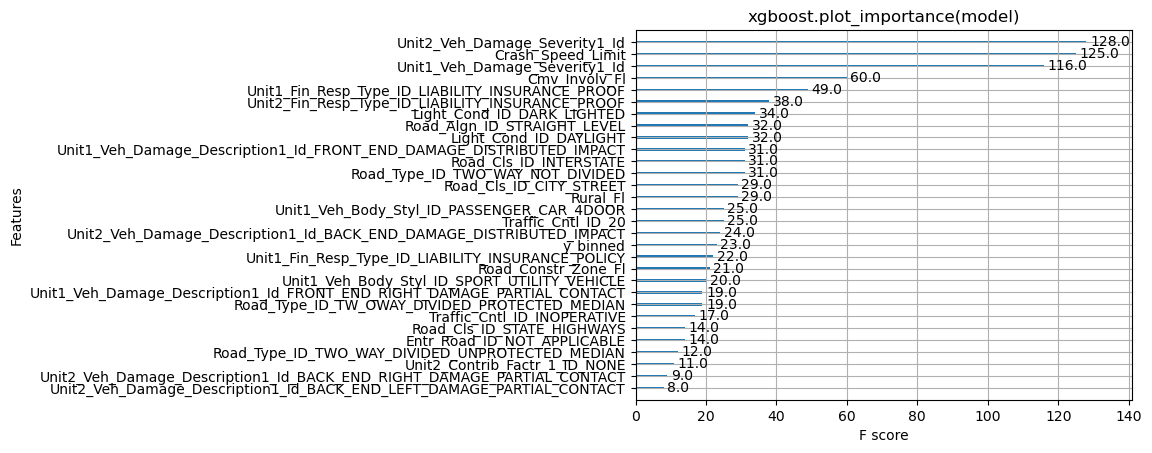

In [378]:
xgboost.plot_importance(xgb_clf2, importance_type='weight',  # Can be changed to 'weight', 'gain', or 'cover'
    max_num_features=30,       # Show only the top 20 features
    title="Top 20 Feature Importances")
pl.title("xgboost.plot_importance(model)")
pl.show()

C:\Users\S-Kumar\AppData\Local\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


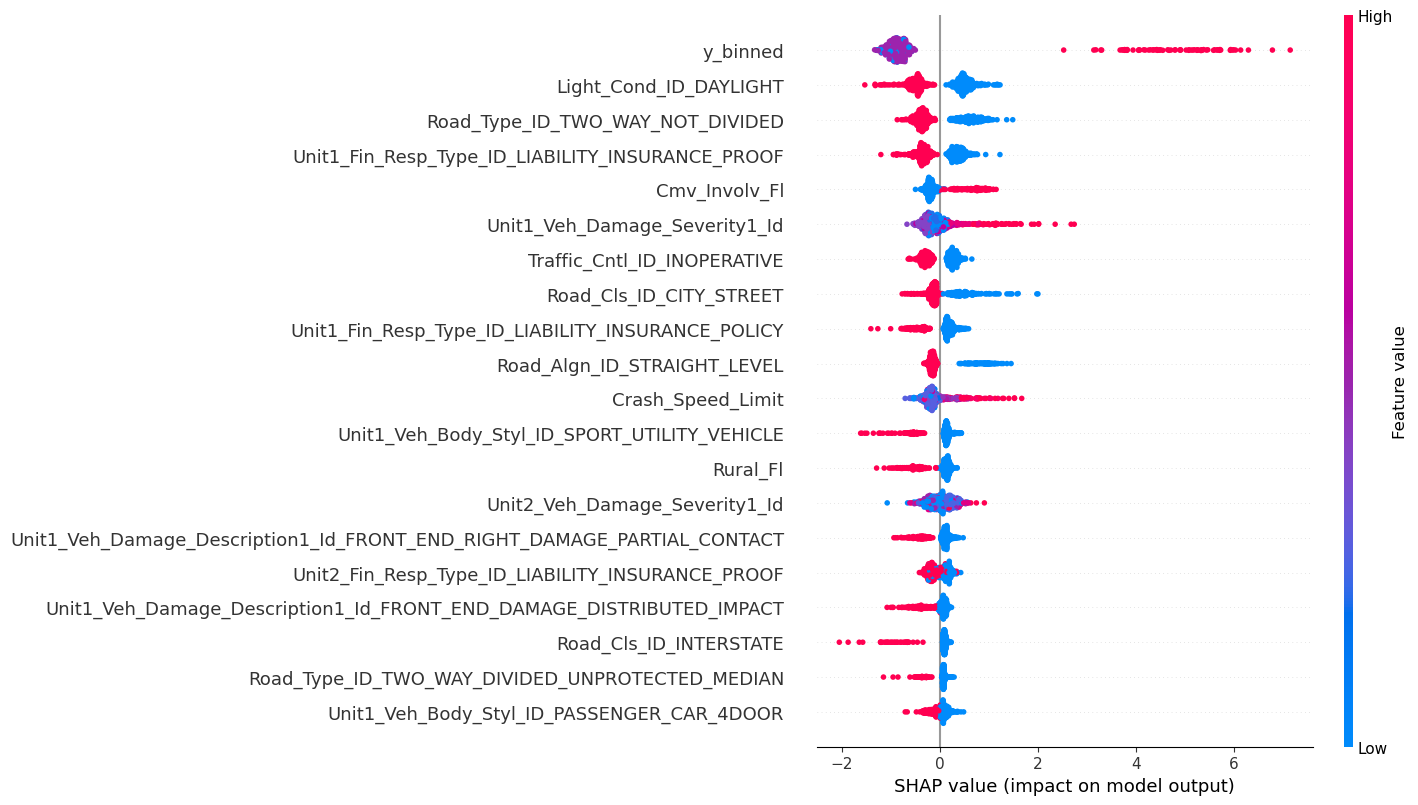

In [357]:
# Visualize SHAP values: 
# 1. Summary Plot : shows the impact of all features for all samples:
shap.summary_plot(shap_values, X_test2)

In [392]:
# Dependence plot: shows the effect of a single feature across the entire dataset
#feature_name = "Unit1_Veh_Damage_Severity1_Id"
#if feature_name in X_test2.columns:
    # Plot the dependence plot
 #   shap.dependence_plot(feature_name, shap_values, X_test2)
#else:
 #   print(f"Feature '{feature_name}' not found in the dataset.")

In [360]:
# Force plot for a single prediction
shap.force_plot(shap_values[0].base_values, shap_values[0].values, X_test2.iloc[0])

In [364]:
# Force plot for multiple predictions
shap.force_plot(shap_values[:100].base_values, shap_values[:100].values, X_test.iloc[:100])